In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime as dt
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
import requests
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Coinbase Utility Functions

In [5]:
def get_coinbase_historical_price_data(
    client,
    ticker,
    start_timestamp,
    end_timestamp,
    granularity="ONE_DAY",
    retries=3,
    delay=5,
):
    """
    Generic candle puller for Coinbase Advanced Trade RESTClient.get_candles().

    granularity examples:
      ONE_MINUTE, FIVE_MINUTE, FIFTEEN_MINUTE, THIRTY_MINUTE,
      ONE_HOUR, TWO_HOUR, FOUR_HOUR, SIX_HOUR, ONE_DAY
    """
    attempts = 0
    while attempts < retries:
        try:
            candle_list = client.get_candles(
                product_id=ticker,
                start=int(start_timestamp),
                end=int(end_timestamp),
                granularity=granularity,
            ).candles

            if not candle_list:
                cols = ["open", "high", "low", "close", "volume"]
                return pd.DataFrame(columns=cols).rename_axis("date")

            candle_data = []
            for c in candle_list:
                candle_data.append(
                    {
                        "date": c["start"],  # epoch seconds
                        "low": float(c["low"]),
                        "high": float(c["high"]),
                        "open": float(c["open"]),
                        "close": float(c["close"]),
                        "volume": float(c["volume"]),
                    }
                )

            df = pd.DataFrame(candle_data)
            if df.empty or "date" not in df.columns:
                cols = ["open", "high", "low", "close", "volume"]
                return pd.DataFrame(columns=cols).rename_axis("date")

            # epoch seconds -> tz-aware UTC -> drop tz (tz-naive UTC)
            s = pd.to_datetime(pd.to_numeric(df["date"], errors="coerce"), unit="s", utc=True).dt.tz_localize(None)

            # Only normalize for daily bars; keep intraday timestamps intact
            if granularity == "ONE_DAY":
                s = s.dt.normalize()

            df["date"] = s
            df = df.set_index("date").sort_index().rename_axis("date")

            return df

        except requests.exceptions.ConnectionError as e:
            print(f"Connection error: {e}. Retrying in {delay} seconds...")
            attempts += 1
            time.sleep(delay)

    raise Exception("Max retries exceeded. Could not connect to Coinbase API.")


In [8]:
def save_historical_crypto_prices_from_coinbase(
    ticker,
    user_start_date=False,
    start_date=None,
    end_date=None,
    save_to_file=False,
    portfolio_name="Default",
    granularity="ONE_DAY",
):
    """
    Pull historical candles for a single ticker at the requested granularity.

    Note: Coinbase candle endpoints have request caps (commonly 300 candles per call),
    so we chunk requests.
    """
    client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)

    if user_start_date:
        start_date = pd.Timestamp(start_date)
    else:
        start_date = cn.coinbase_start_date_by_ticker_dict.get(ticker)
        start_date = pd.Timestamp(start_date)
        if start_date is None:
            print(f"Start date for {ticker} is not included in the dictionary!")
            return None

    end_date = pd.Timestamp(end_date)

    # seconds per bar (used to step chunks without gaps)
    granularity_to_seconds = {
        "ONE_MINUTE": 60,
        "FIVE_MINUTE": 300,
        "FIFTEEN_MINUTE": 900,
        "THIRTY_MINUTE": 1800,
        "ONE_HOUR": 3600,
        "TWO_HOUR": 7200,
        "FOUR_HOUR": 14400,
        "SIX_HOUR": 21600,
        "ONE_DAY": 86400,
    }
    bar_sec = granularity_to_seconds.get(granularity)
    if bar_sec is None:
        raise ValueError(f"Unsupported granularity: {granularity}")

    # Keep your old 6-week chunking (works great for ONE_DAY and FOUR_HOUR),
    # but ensure we never step by +1 day when doing intraday.
    temp_start = start_date
    current_end = temp_start

    dfs = []
    while current_end < end_date:
        # 6 weeks is safe for FOUR_HOUR (≈252 candles) under the typical 300 limit :contentReference[oaicite:1]{index=1}
        current_end = pd.to_datetime(temp_start) + dt.timedelta(weeks=6)
        if current_end > end_date:
            current_end = end_date

        start_ts = int(pd.Timestamp(temp_start).timestamp())
        end_ts = int(pd.Timestamp(current_end).timestamp())

        df_chunk = get_coinbase_historical_price_data(
            client=client,
            ticker=ticker,
            start_timestamp=start_ts,
            end_timestamp=end_ts,
            granularity=granularity,
        )
        dfs.append(df_chunk)

        # advance by exactly one bar to avoid duplicates and avoid gaps
        temp_start = pd.to_datetime(current_end) + pd.Timedelta(seconds=bar_sec)

    if not dfs:
        cols = ["open", "high", "low", "close", "volume"]
        return pd.DataFrame(columns=cols).rename_axis("date")

    df = pd.concat(dfs, axis=0)
    df = df[~df.index.duplicated(keep="last")].sort_index()

    # optional: save_to_file logic can stay as you had it (not shown in your snippet)

    return df


In [12]:
cn_ticker_list = cn.coinbase_start_date_by_ticker_dict

In [14]:
cn_ticker_list

{'BTC-USD': '2016-01-01',
 'ETH-USD': '2016-06-01',
 'SOL-USD': '2021-06-01',
 'ADA-USD': '2021-03-01',
 'AVAX-USD': '2021-09-01',
 'DOT-USD': '2021-06-01',
 'ATOM-USD': '2020-01-01',
 'LTC-USD': '2016-09-01',
 'XRP-USD': '2023-06-01',
 'ALGO-USD': '2019-08-01',
 'XLM-USD': '2019-02-01',
 'TON-USD': '2025-11-18',
 'NEAR-USD': '2022-09-01',
 'ICP-USD': '2021-05-10',
 'HBAR-USD': '2022-10-13',
 'SUI-USD': '2023-05-18',
 'CRO-USD': '2021-11-01',
 'APT-USD': '2022-10-19',
 'XTZ-USD': '2019-08-06',
 'EGLD-USD': '2022-12-07',
 'FIL-USD': '2020-12-09',
 'SEI-USD': '2023-08-15',
 'TIA-USD': '2023-11-01',
 'KAVA-USD': '2023-01-19',
 'ROSE-USD': '2022-04-26',
 'MATIC-USD': '2021-02-01',
 'SKL-USD': '2021-02-01',
 'OP-USD': '2022-06-01',
 'ARB-USD': '2023-03-23',
 'POL-USD': '2024-09-04',
 'IMX-USD': '2021-12-09',
 'STRK-USD': '2024-02-21',
 'BLAST-USD': '2024-06-26',
 'ZK-USD': '2024-09-25',
 'LRC-USD': '2020-09-15',
 'ZORA-USD': '2025-04-24',
 'METIS-USD': '2022-06-28',
 'STX-USD': '2022-01-20'

In [16]:
ticker_list = []
exclude_list = ['USDT-USD','DAI-USD','USD1-USD','PAX-USD','MATIC-USD']
for ticker, date in cn_ticker_list.items():
    if (pd.Timestamp(cn_ticker_list[ticker]).date() <= pd.Timestamp('2022-04-01').date()) & (ticker not in exclude_list):
        ticker_list.append(ticker)

In [18]:
print(len(ticker_list))
ticker_list

40


['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'DOT-USD',
 'ATOM-USD',
 'LTC-USD',
 'ALGO-USD',
 'XLM-USD',
 'ICP-USD',
 'CRO-USD',
 'XTZ-USD',
 'FIL-USD',
 'SKL-USD',
 'IMX-USD',
 'LRC-USD',
 'STX-USD',
 'DOGE-USD',
 'SHIB-USD',
 'LINK-USD',
 'FET-USD',
 'GRT-USD',
 'RNDR-USD',
 'OXT-USD',
 'AIOZ-USD',
 'DIA-USD',
 'KRL-USD',
 'UNI-USD',
 'AAVE-USD',
 'AMP-USD',
 'COMP-USD',
 'MKR-USD',
 'SNX-USD',
 'SUSHI-USD',
 'CRV-USD',
 'BAL-USD',
 '1INCH-USD',
 'MANA-USD',
 'REQ-USD']

In [20]:
def get_coinbase_price_data_for_ticker_list(start_date, end_date, ticker_list, fill_missing=True):

    df_dict_by_ticker = {}
    ticker_list_len = len(ticker_list)
    loop_start = 0
    loop_end = 0
    counter = 0
    while counter < ticker_list_len:
        loop_start = counter
        if counter == 40:
            loop_end = ticker_list_len
        else:
            loop_end = counter + 10
        print(counter, loop_start, loop_end, ticker_list[loop_start: loop_end])
        for t in ticker_list[loop_start: loop_end]:
            df_dict_by_ticker[t] = save_historical_crypto_prices_from_coinbase(
                ticker=t,
                user_start_date=True,
                start_date=start_date,
                end_date=end_date,
                portfolio_name="Default",
                granularity="FOUR_HOUR",
            )
        counter += 10
    
    # Optional: one combined frame (MultiIndex: ticker, date)
    df_all = pd.concat(df_dict_by_ticker, names=["ticker", "date"]).sort_index()

    # --- build expected 4H grid ---
    start = pd.Timestamp(start_date).floor("4H")
    end = pd.Timestamp(end_date).ceil("4H")
    expected_dates = pd.date_range(start=start, end=end, freq="4H")#, inclusive="left")

    full_index = pd.MultiIndex.from_product(
        [ticker_list, expected_dates],
        names=["ticker", "date"]
    )

    # --- align everything to full grid ---
    df_all = df_all.reindex(full_index)

    # --- flag missing bars ---
    df_all["imputed"] = df_all["close"].isna()

    if fill_missing:
        # Forward-fill ONLY close per ticker (for alignment / valuation)
        df_all["close"] = df_all.groupby(level=0)["close"].ffill()

        # For imputed rows: set OHLC = close, volume=0
        m = df_all["imputed"]
        for col in ["open", "high", "low"]:
            df_all.loc[m, col] = df_all.loc[m, "close"]
        df_all.loc[m, "volume"] = 0.0

    # if you want a flat frame:
    df_all = df_all.reset_index()

    return df_all

In [22]:
%%time
start_date = "2022-04-01"
end_date   = "2024-12-31"
# df_ticker_price_impute = get_coinbase_price_data_for_ticker_list(start_date, end_date, ticker_list, fill_missing=True)

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 6.91 μs


In [ ]:
df_ticker_check = df_ticker_price_impute.groupby(['date']).agg({'ticker':'nunique'})
df_ticker_check[df_ticker_check['ticker'] < 40]

In [ ]:
print(df_ticker_price.shape, df_ticker_price_impute.shape)

In [ ]:
df_ticker_price.shape

In [ ]:
## Save Files to Parquet for later use
df_ticker_price_impute.to_parquet(
    f"/Users/adheerchauhan/git/trend_following/data_folder/coinbase_4_min_bar_data/coinbase_ohlcv_4min_{start_date}-{end_date}.parquet",
    index=False,
    compression="zstd",  # great balance of size + speed
)

In [24]:
## Read Parquet Files
df_ticker_price_impute = pd.read_parquet(f"/Users/adheerchauhan/git/trend_following/data_folder/coinbase_4_min_bar_data/coinbase_ohlcv_4min_{start_date}-{end_date}.parquet")

In [26]:
df_ticker_price_impute.head()

,ticker,date,low,high,open,close,volume,imputed
0,BTC-USD,2022-04-01 00:00:00,44232.86,45655.42,45525.25,44614.99,4498.191859,False
1,BTC-USD,2022-04-01 04:00:00,44554.06,45115.70,44612.73,45030.70,1866.920775,False
2,BTC-USD,2022-04-01 08:00:00,45009.73,45338.35,45030.71,45082.74,1735.690901,False
3,BTC-USD,2022-04-01 12:00:00,44722.00,46739.24,45081.52,46545.39,5000.839037,False
4,BTC-USD,2022-04-01 16:00:00,45906.00,46607.89,46545.31,46390.69,3498.550271,False


In [28]:
df_ticker_price_impute.shape

(241240, 8)

In [30]:
df_ticker_price_impute.groupby(['ticker']).size()

ticker
1INCH-USD    6031
AAVE-USD     6031
ADA-USD      6031
AIOZ-USD     6031
ALGO-USD     6031
AMP-USD      6031
ATOM-USD     6031
AVAX-USD     6031
BAL-USD      6031
BTC-USD      6031
COMP-USD     6031
CRO-USD      6031
CRV-USD      6031
DIA-USD      6031
DOGE-USD     6031
DOT-USD      6031
ETH-USD      6031
FET-USD      6031
FIL-USD      6031
GRT-USD      6031
ICP-USD      6031
IMX-USD      6031
KRL-USD      6031
LINK-USD     6031
LRC-USD      6031
LTC-USD      6031
MANA-USD     6031
MKR-USD      6031
OXT-USD      6031
REQ-USD      6031
RNDR-USD     6031
SHIB-USD     6031
SKL-USD      6031
SNX-USD      6031
SOL-USD      6031
STX-USD      6031
SUSHI-USD    6031
UNI-USD      6031
XLM-USD      6031
XTZ-USD      6031
dtype: int64

## Build Return Features

In [34]:
def calculate_z_score(df, return_col, date_col, z_score_col_name):

    return_mean = df.groupby([date_col])[return_col].transform('mean')
    return_std = df.groupby([date_col])[return_col].transform('std').replace(0, np.nan)
    df[z_score_col_name] = (df[return_col] - return_mean) / return_std

    return df
    

def build_return_features(df, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50):

    df_returns = df.copy()

    ## Get Previour 4 hour returns
    ticker_group_close = df_returns.groupby(['ticker'])['close']
    df_returns['close_log_return_prev_4h'] = np.log(ticker_group_close.shift(1) / ticker_group_close.shift(2))

    ## Require a minimum number of tickers to calculate Z-Score for a given bar
    ticker_count_by_date = df_returns.groupby(['date'])['ticker'].transform('nunique')
    df_returns = df_returns[ticker_count_by_date >= min_z_score_ticker_count]

    ## Calculate cross-sectional Z-Score across all tickers per bar
    df_returns = calculate_z_score(df_returns, return_col='close_log_return_prev_4h', date_col='date', z_score_col_name='close_log_return_z_score_prev_4h')

    ## Get forward return for specified period (Open(T) to Open(T+H))
    df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = np.log(df_returns.groupby(['ticker'])['open'].shift(-fwd_return_period) / df_returns['open'])

    ## Winsorize Forward Return to reduce data glitches
    if winsorize_fwd_return:
        df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'].clip(-fwd_return_cap, fwd_return_cap)

    return df_returns

In [36]:
df_returns = build_return_features(df_ticker_price_impute, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50)

In [38]:
df_returns.shape

(241240, 11)

In [40]:
df_returns[df_returns['date'] == pd.Timestamp('2022-04-01 08:00:00')]

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h
2,BTC-USD,2022-04-01 08:00:00,45009.730000,45338.350000,45030.710000,45082.740000,1.735691e+03,False,0.009275,-0.501776,0.029748
6033,ETH-USD,2022-04-01 08:00:00,3268.750000,3304.620000,3280.010000,3286.140000,1.752434e+04,False,0.008881,-0.516191,0.056711
12064,SOL-USD,2022-04-01 08:00:00,124.050000,127.130000,126.460000,124.430000,1.319039e+05,False,0.035899,0.473548,0.083407
18095,ADA-USD,2022-04-01 08:00:00,1.130900,1.165000,1.151300,1.131600,1.068237e+07,False,0.023733,0.027878,0.018929
24126,AVAX-USD,2022-04-01 08:00:00,92.860000,95.240000,94.250000,92.960000,7.344129e+04,False,0.020907,-0.075664,0.050380
30157,DOT-USD,2022-04-01 08:00:00,21.060000,21.510000,21.400000,21.090000,1.118278e+05,False,0.022207,-0.028016,0.028560
36188,ATOM-USD,2022-04-01 08:00:00,28.290000,28.790000,28.670000,28.350000,6.363199e+04,False,0.021150,-0.066755,0.032261
42219,LTC-USD,2022-04-01 08:00:00,121.900000,123.290000,122.660000,122.250000,2.144202e+04,False,0.013954,-0.330354,0.029165
48250,ALGO-USD,2022-04-01 08:00:00,0.920600,0.939600,0.935100,0.922400,1.905644e+06,False,0.033492,0.385377,0.007139
54281,XLM-USD,2022-04-01 08:00:00,0.224391,0.227201,0.225855,0.225173,1.154578e+07,False,0.009096,-0.508328,0.025593


In [42]:
return_cols = ['close_log_return_prev_4h','fwd_open_log_return_12h']
df_signal = df_returns.dropna(subset=return_cols).copy()

In [44]:
## Analyze the Decile Performance by date for this signal
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

df_signal["quantile_bucket"] = df_signal.groupby("date", group_keys=False).apply(
    lambda g: cs_bucket(g, "close_log_return_z_score_prev_4h", q=10)
)

bucket_stats = (
    df_signal.dropna(subset=["quantile_bucket"])
    .groupby("quantile_bucket")["fwd_open_log_return_12h"]
    .agg(["mean", "std", "count"])
)
bucket_stats["t_stat"] = bucket_stats["mean"] / (bucket_stats["std"] / np.sqrt(bucket_stats["count"]))
## Denominator here is the Standard Error calculated as STD / sqrt(N). The t-stat calculates how many
## standard errors the observed mean is away from 0
## T-Stat assumes IID (which may not be the case) and n is large enough where the distribution is normal using Central Limit Theorem
bucket_stats


,mean,std,count,t_stat
quantile_bucket,,,,
0,0.000571,0.041397,24164,2.143720
1,0.000351,0.034979,24145,1.560822
2,0.000167,0.033932,24167,0.764824
3,0.000113,0.033033,24076,0.531072
4,-0.000073,0.033050,24108,-0.343178
5,-0.000140,0.032702,24104,-0.666957
6,-0.000233,0.033267,24089,-1.084823
7,-0.000459,0.034635,24059,-2.056940
8,-0.000570,0.036960,24055,-2.391333


In [45]:
## Analyze the Qunitlie Performance by date for this signal
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

df_signal["quantile_bucket"] = df_signal.groupby("date", group_keys=False).apply(
    lambda g: cs_bucket(g, "close_log_return_z_score_prev_4h", q=5)
)

bucket_stats = (
    df_signal.dropna(subset=["quantile_bucket"])
    .groupby("quantile_bucket")["fwd_open_log_return_12h"]
    .agg(["mean", "std", "count"])
)
bucket_stats["t_stat"] = bucket_stats["mean"] / (bucket_stats["std"] / np.sqrt(bucket_stats["count"]))
## Denominator here is the Standard Error calculated as STD / sqrt(N). The t-stat calculates how many
## standard errors the observed mean is away from 0
## T-Stat assumes IID (which may not be the case) and n is large enough where the distribution is normal using Central Limit Theorem
bucket_stats


,mean,std,count,t_stat
quantile_bucket,,,,
0,0.000463,0.038325,48305,2.654359
1,0.000135,0.033470,48241,0.885081
2,-0.000100,0.032895,48206,-0.666324
3,-0.000347,0.033957,48148,-2.242080
4,-0.001576,0.043057,48140,-8.030642


In [46]:
df_signal[df_signal.date == pd.Timestamp('2022-04-26 08:00:00')].sort_values('close_log_return_z_score_prev_4h')#.head()

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket
199175,SNX-USD,2022-04-26 08:00:00,6.027000,6.218000,6.042000,6.124000,2.138039e+05,False,-0.020474,-1.884958,-0.076862,0
150927,AIOZ-USD,2022-04-26 08:00:00,0.174600,0.183100,0.178500,0.176600,1.362029e+05,False,-0.020012,-1.852753,-0.088387,0
30307,DOT-USD,2022-04-26 08:00:00,17.770000,18.070000,17.900000,17.860000,9.355814e+04,False,-0.005574,-0.846933,-0.059857,0
42369,LTC-USD,2022-04-26 08:00:00,103.840000,104.920000,104.050000,104.400000,2.117506e+04,False,-0.003933,-0.732577,-0.039301,0
12214,SOL-USD,2022-04-26 08:00:00,99.750000,101.570000,100.870000,100.510000,7.474932e+04,False,-0.001189,-0.541415,-0.043150,0
229330,MANA-USD,2022-04-26 08:00:00,1.917000,1.976000,1.970000,1.929000,7.131466e+05,False,-0.000508,-0.493974,-0.073718,0
114741,SHIB-USD,2022-04-26 08:00:00,0.000024,0.000025,0.000024,0.000024,3.537771e+11,False,-0.000412,-0.487289,-0.049799,0
169020,UNI-USD,2022-04-26 08:00:00,8.680000,8.780000,8.710000,8.690000,2.633666e+04,False,0.000000,-0.458602,-0.071374,0
156958,DIA-USD,2022-04-26 08:00:00,0.850000,0.860000,0.860000,0.850000,5.570900e+03,False,0.000000,-0.458602,-0.059898,0
138865,RNDR-USD,2022-04-26 08:00:00,1.650000,1.720000,1.710000,1.670000,2.099039e+04,False,0.000000,-0.458602,-0.098238,0


In [47]:
## Information Coefficient: calculates the correlation between the signal and future returns
## This is usually calculated cross-sectionally at each timestamp and analyzed over time
def spearman_ic(group, signal="close_log_return_z_score_prev_4h", label="fwd_open_log_return_12h"):
    g = group[[signal, label]].dropna()
    if len(g) < 10:
        return np.nan
    return g[signal].corr(g[label], method="spearman")

ic_ts = df_signal.groupby("date").apply(spearman_ic)
ic_ts.describe()
## Negative IC shows inverse correlation which is what we want
## Whwen Z-Score is negative, the coins bounce back with positive forward returns

count    6026.000000
mean       -0.051811
std         0.209057
min        -0.722514
25%        -0.195826
50%        -0.053659
75%         0.090994
max         0.774859
dtype: float64

In [48]:
ic_ts.head()

date
2022-04-01 08:00:00    0.054972
2022-04-01 12:00:00   -0.247280
2022-04-01 16:00:00   -0.213508
2022-04-01 20:00:00   -0.368480
2022-04-02 00:00:00   -0.251782
dtype: float64

In [49]:
ic_ts = df_signal.groupby("date").apply(spearman_ic)

n = ic_ts.count()
ic_mean = ic_ts.mean()
ic_std = ic_ts.std(ddof=1)
ic_se = ic_std / np.sqrt(n) if n > 0 else np.nan
ic_t = ic_mean / ic_se if (n > 1 and ic_se != 0) else np.nan
ic_ir = ic_mean / ic_std if ic_std not in (0, np.nan) else np.nan
hit_rate = (ic_ts > 0).mean() if n > 0 else np.nan

## Calculate the IC for each percentile from 1 to 99
pct = ic_ts.dropna().quantile([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]) if n > 0 else pd.Series(dtype=float)

# 3) Print everything
print("=== Information Coefficient (Spearman Rank IC) Summary ===")
print(f"Dates (non-NaN):              {n}")
print(f"Mean IC:                      {ic_mean:.6f}")
print(f"Std IC:                       {ic_std:.6f}")
print(f"Std Error (mean):             {ic_se:.6f}")
print(f"t-stat (mean IC):             {ic_t:.3f}")
print(f"Information Ratio (mean/std): {ic_ir:.3f}")
print(f"Hit rate (IC > 0):            {hit_rate:.3%}")
print(f"Min / Max IC:                 {ic_ts.min():.6f} / {ic_ts.max():.6f}")
print("")
print("Percentiles:")
for q, v in pct.items():
    print(f"  p{int(q*100):02d}: {v:.6f}")


=== Information Coefficient (Spearman Rank IC) Summary ===
Dates (non-NaN):              6026
Mean IC:                      -0.051811
Std IC:                       0.209057
Std Error (mean):             0.002693
t-stat (mean IC):             -19.238
Information Ratio (mean/std): -0.248
Hit rate (IC > 0):            39.993%
Min / Max IC:                 -0.722514 / 0.774859

Percentiles:
  p01: -0.517777
  p05: -0.400141
  p10: -0.320544
  p25: -0.195826
  p50: -0.053659
  p75: 0.090994
  p90: 0.218407
  p95: 0.289386
  p99: 0.430883


In [51]:
## Creating a naive equal-weighted strategy going long the bottom 20% of coins
# Create a flag for the bottom 20% of coins by Z-Score
q = 0.2  # bottom 20%
df_signal["naive_trade_signal"] = df_signal.groupby("date")["close_log_return_z_score_prev_4h"].transform(
    lambda s: s <= s.quantile(q)
)

# Equal weight among selected per timestamp
sel_count = df_signal.groupby("date")["naive_trade_signal"].transform("sum").replace(0, np.nan)
df_signal["weight"] = (df_signal["naive_trade_signal"] / sel_count).fillna(0.0)

# Calculate the forward return of the strategy going out to 12 hours after a naive position is taken
basket_fwd = df_signal.groupby("date").apply(lambda g: float((g["weight"] * g["fwd_open_log_return_12h"]).sum()))
basket_fwd.name = "basket_fwd_12h"
basket_fwd.describe()


count    6026.000000
mean        0.000474
std         0.028781
min        -0.190031
25%        -0.012618
50%         0.001119
75%         0.014827
max         0.218609
Name: basket_fwd_12h, dtype: float64

In [52]:
basket_fwd.head(20)

date
2022-04-01 08:00:00    0.061112
2022-04-01 12:00:00    0.075447
2022-04-01 16:00:00    0.028929
2022-04-01 20:00:00    0.019602
2022-04-02 00:00:00    0.027706
2022-04-02 04:00:00   -0.023033
2022-04-02 08:00:00   -0.010332
2022-04-02 12:00:00   -0.029200
2022-04-02 16:00:00   -0.008265
2022-04-02 20:00:00    0.015526
2022-04-03 00:00:00    0.026070
2022-04-03 04:00:00    0.015417
2022-04-03 08:00:00   -0.008555
2022-04-03 12:00:00    0.009572
2022-04-03 16:00:00   -0.003032
2022-04-03 20:00:00    0.002927
2022-04-04 00:00:00   -0.004495
2022-04-04 04:00:00   -0.038091
2022-04-04 08:00:00   -0.025492
2022-04-04 12:00:00   -0.008386
Name: basket_fwd_12h, dtype: float64

In [54]:
import numpy as np
import pandas as pd

df = df_returns.sort_values(["ticker","date"]).copy()

# --- Prior-bar OHLCV features (available at open_t) ---
g = df.groupby("ticker", group_keys=False)

df["volume_prev"]   = g["volume"].shift(1)
df["high_prev"]  = g["high"].shift(1)
df["low_prev"]   = g["low"].shift(1)
df["close_prev"] = g["close"].shift(1)
df["open_prev"]  = g["open"].shift(1)

# Range of prior bar (you can use /close_prev or /open_prev; pick one)
df["range_prev"] = (df["high_prev"] - df["low_prev"]) / df["close_prev"]

# Rolling z-scores per ticker (volume spike / range shock relative to its own history)
# Window ~ 10 days of 4h bars: 10*6 = 60
W = 60

def rolling_z(x, window=W):
    mu = x.rolling(window, min_periods=window//2).mean()
    sd = x.rolling(window, min_periods=window//2).std()
    return (x - mu) / sd.replace(0, np.nan)

df["volume_z_prev"]   = g["volume_prev"].apply(rolling_z)
df["range_z_prev"] = g["range_prev"].apply(rolling_z)

# Flags: high/low
VOL_Z_TH = 1.5
RNG_Z_TH = 1.5
df["high_vol_spike"]   = df["volume_z_prev"]   >= VOL_Z_TH
df["high_range_shock"] = df["range_z_prev"] >= RNG_Z_TH


In [55]:
BTC = "BTC-USD"
btc = df[df["ticker"] == BTC].sort_values("date")[["date","close_prev"]].copy()

# BTC MA on prior close (choose window)
MA_W = 150  # ~25 days of 4h bars
btc["btc_ma"] = btc["close_prev"].rolling(MA_W, min_periods=MA_W//2).mean()

btc["risk_on"] = btc["close_prev"] > btc["btc_ma"]
btc_regime = btc[["date","risk_on"]]

df = df.merge(btc_regime, on="date", how="left")
# If early history has NaN risk_on (MA not ready), you can default to False or drop:
df = df.dropna(subset=["risk_on"])


In [56]:
df.head(200)

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,volume_prev,high_prev,low_prev,close_prev,open_prev,range_prev,volume_z_prev,range_z_prev,high_vol_spike,high_range_shock,risk_on
0,1INCH-USD,2022-04-01 00:00:00,1.670,1.792,1.777,1.708,193718.75,False,NaN,NaN,-0.018745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,1INCH-USD,2022-04-01 04:00:00,1.707,1.756,1.709,1.755,64858.85,False,NaN,NaN,0.062378,193718.75,1.792,1.670,1.708,1.777,0.071429,NaN,NaN,False,False,False
2,1INCH-USD,2022-04-01 08:00:00,1.738,1.772,1.757,1.747,43729.16,False,0.027146,0.152888,0.068196,64858.85,1.756,1.707,1.755,1.709,0.027920,NaN,NaN,False,False,False
3,1INCH-USD,2022-04-01 12:00:00,1.710,1.831,1.744,1.816,149897.91,False,-0.004569,0.127891,0.074558,43729.16,1.772,1.738,1.747,1.757,0.019462,NaN,NaN,False,False,False
4,1INCH-USD,2022-04-01 16:00:00,1.809,1.885,1.819,1.880,167483.50,False,0.038736,-0.044778,0.058196,149897.91,1.831,1.710,1.816,1.744,0.066630,NaN,NaN,False,False,False
5,1INCH-USD,2022-04-01 20:00:00,1.856,1.890,1.881,1.882,219778.94,False,0.034635,0.904957,0.019479,167483.50,1.885,1.809,1.880,1.819,0.040426,NaN,NaN,False,False,False
6,1INCH-USD,2022-04-02 00:00:00,1.869,1.953,1.879,1.928,228449.80,False,0.001063,0.306189,0.070872,219778.94,1.890,1.856,1.882,1.881,0.018066,NaN,NaN,False,False,False
7,1INCH-USD,2022-04-02 04:00:00,1.899,1.934,1.928,1.921,77715.50,False,0.024148,1.017239,0.023072,228449.80,1.953,1.869,1.928,1.879,0.043568,NaN,NaN,False,False,False
8,1INCH-USD,2022-04-02 08:00:00,1.907,2.098,1.918,2.019,631140.71,False,-0.003637,-0.736465,0.031309,77715.50,1.934,1.899,1.921,1.928,0.018220,NaN,NaN,False,False,False
9,1INCH-USD,2022-04-02 12:00:00,1.919,2.031,2.017,1.975,296032.72,False,0.049756,2.584977,-0.047205,631140.71,2.098,1.907,2.019,1.918,0.094601,NaN,NaN,False,False,False


In [57]:
q = 0.2
df["enter"] = df.groupby("date")["close_log_return_z_score_prev_4h"].transform(lambda s: s <= s.quantile(q))

# Use only rows where we have a label
df_eval = df.dropna(subset=["fwd_open_log_return_12h", "close_log_return_z_score_prev_4h"]).copy()

# Evaluate only entries (recommended) – otherwise you’re not measuring the strategy edge
df_trades = df_eval[df_eval["enter"]].copy()


In [58]:
def summarize(group, label="fwd_open_log_return_12h"):
    x = group[label].dropna()
    n = x.size
    if n < 30:
        return pd.Series({"mean": np.nan, "std": np.nan, "count": n, "t_stat": np.nan})
    mu = x.mean()
    sd = x.std(ddof=1)
    t  = mu / (sd / np.sqrt(n)) if sd > 0 else np.nan
    return pd.Series({"mean": mu, "std": sd, "count": n, "t_stat": t})

# 1) Volume spike high vs low
vol_table = df_trades.groupby("high_vol_spike").apply(summarize)
vol_table.index = vol_table.index.map({False: "Low vol spike", True: "High vol spike"})
vol_table

# 2) Range shock high vs low
rng_table = df_trades.groupby("high_range_shock").apply(summarize)
rng_table.index = rng_table.index.map({False: "Low range shock", True: "High range shock"})
rng_table

# 3) BTC regime risk-on vs risk-off
reg_table = df_trades.groupby("risk_on").apply(summarize)
reg_table.index = reg_table.index.map({False: "Risk-off", True: "Risk-on"})
reg_table


,mean,std,count,t_stat
risk_on,,,,
Risk-off,-0.000410,0.038352,22870.0,-1.616860
Risk-on,0.001248,0.038284,25435.0,5.197724


In [61]:
vol_table

,mean,std,count,t_stat
high_vol_spike,,,,
Low vol spike,0.000393,0.036835,43950.0,2.239297
High vol spike,0.001163,0.050979,4355.0,1.505812


In [62]:
rng_table

,mean,std,count,t_stat
high_range_shock,,,,
Low range shock,0.000335,0.036635,44046.0,1.918849
High range shock,0.001786,0.052705,4259.0,2.211025


In [63]:
vol_x_reg = df_trades.groupby(["risk_on","high_vol_spike"]).apply(summarize).reset_index()
vol_x_reg["risk_on"] = vol_x_reg["risk_on"].map({False:"Risk-off", True:"Risk-on"})
vol_x_reg["high_vol_spike"] = vol_x_reg["high_vol_spike"].map({False:"Low vol spike", True:"High vol spike"})
vol_x_reg


,risk_on,high_vol_spike,mean,std,count,t_stat
0,Risk-off,Low vol spike,-0.000225,0.036702,20772.0,-0.885442
1,Risk-off,High vol spike,-0.002237,0.051911,2098.0,-1.974144
2,Risk-on,Low vol spike,0.000948,0.036946,23178.0,3.906968
3,Risk-on,High vol spike,0.004324,0.049901,2257.0,4.116889


In [64]:
three_way = df_trades.groupby(["risk_on","high_vol_spike","high_range_shock"]).apply(summarize).reset_index()
three_way["risk_on"] = three_way["risk_on"].map({False:"Risk-off", True:"Risk-on"})
three_way["high_vol_spike"] = three_way["high_vol_spike"].map({False:"Low vol spike", True:"High vol spike"})
three_way["high_range_shock"] = three_way["high_range_shock"].map({False:"Low range", True:"High range"})
three_way.sort_values(["risk_on","high_vol_spike","high_range_shock"])


,risk_on,high_vol_spike,high_range_shock,mean,std,count,t_stat
3,Risk-off,High vol spike,High range,-0.002183,0.058882,1157.0,-1.260890
2,Risk-off,High vol spike,Low range,-0.002305,0.041807,941.0,-1.690976
1,Risk-off,Low vol spike,High range,0.000187,0.050084,1006.0,0.118543
0,Risk-off,Low vol spike,Low range,-0.000246,0.035889,19766.0,-0.965571
7,Risk-on,High vol spike,High range,0.006431,0.058271,1020.0,3.524641
6,Risk-on,High vol spike,Low range,0.002587,0.041701,1237.0,2.182090
5,Risk-on,Low vol spike,High range,0.003144,0.040855,1076.0,2.524113
4,Risk-on,Low vol spike,Low range,0.000841,0.036743,22102.0,3.403821


In [65]:
df[df.ticker == 'AAVE-USD'].head(20)

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,volume_prev,high_prev,low_prev,close_prev,open_prev,range_prev,volume_z_prev,range_z_prev,high_vol_spike,high_range_shock,risk_on,enter
6031,AAVE-USD,2022-04-01 00:00:00,206.16,220.91,207.01,217.93,37566.335,False,NaN,NaN,0.062858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
6032,AAVE-USD,2022-04-01 04:00:00,215.02,230.64,217.89,225.85,31366.979,False,NaN,NaN,0.117105,37566.335,220.91,206.16,217.93,207.01,0.067682,NaN,NaN,False,False,False,False
6033,AAVE-USD,2022-04-01 08:00:00,218.70,226.02,225.91,220.44,17916.536,False,0.035697,0.466146,0.140353,31366.979,230.64,215.02,225.85,217.89,0.069161,NaN,NaN,False,False,False,False
6034,AAVE-USD,2022-04-01 12:00:00,214.00,248.95,220.44,245.02,68939.822,False,-0.024246,-0.924200,0.104489,17916.536,226.02,218.70,220.44,225.91,0.033206,NaN,NaN,False,False,False,True
6035,AAVE-USD,2022-04-01 16:00:00,244.05,261.29,244.96,260.06,58259.449,False,0.105714,3.053627,0.001509,68939.822,248.95,214.00,245.02,220.44,0.142641,NaN,NaN,False,False,False,False
6036,AAVE-USD,2022-04-01 20:00:00,243.50,260.64,259.95,244.76,23188.976,False,0.059573,2.057740,-0.066852,58259.449,261.29,244.05,260.06,244.96,0.066292,NaN,NaN,False,False,False,False
6037,AAVE-USD,2022-04-02 00:00:00,241.29,257.38,244.72,245.16,24991.545,False,-0.060634,-2.683907,0.002041,23188.976,260.64,243.50,244.76,259.95,0.070028,NaN,NaN,False,False,False,True
6038,AAVE-USD,2022-04-02 04:00:00,240.98,246.28,245.33,243.16,10017.931,False,0.001633,-0.423295,-0.030039,24991.545,257.38,241.29,245.16,244.72,0.065631,NaN,NaN,False,False,False,False
6039,AAVE-USD,2022-04-02 08:00:00,240.93,249.10,243.14,245.29,15393.770,False,-0.008191,-1.061711,-0.004039,10017.931,246.28,240.98,243.16,245.33,0.021796,NaN,NaN,False,False,False,True
6040,AAVE-USD,2022-04-02 12:00:00,235.80,247.67,245.22,238.06,20298.957,False,0.008722,0.318570,-0.029129,15393.770,249.10,240.93,245.29,243.14,0.033308,NaN,NaN,False,False,False,False


In [66]:
df_signal[df_signal.date == pd.Timestamp('2022-04-01 08:00:00')].sort_values('close_log_return_z_score_prev_4h').head(10)

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,naive_trade_signal,weight
156808,DIA-USD,2022-04-01 08:00:00,1.050000,1.060000,1.060000,1.050000,3.767191e+04,False,-0.009390,-1.185494,0.027909,0,True,0.125
162839,KRL-USD,2022-04-01 08:00:00,0.905100,0.951900,0.918500,0.924900,2.307821e+05,False,-0.008568,-1.155389,0.042419,0,True,0.125
199025,SNX-USD,2022-04-01 08:00:00,6.889000,7.424000,6.999000,7.064000,5.409504e+05,False,-0.006265,-1.071033,0.109894,0,True,0.125
150777,AIOZ-USD,2022-04-01 08:00:00,0.231500,0.237000,0.233100,0.237000,1.577417e+05,False,-0.005540,-1.044476,0.039946,0,True,0.125
235211,REQ-USD,2022-04-01 08:00:00,0.247800,0.252600,0.247800,0.252000,7.445030e+05,False,0.005256,-0.648996,0.066353,0,True,0.125
192994,MKR-USD,2022-04-01 08:00:00,2054.220000,2098.670000,2073.950000,2096.720000,1.657502e+02,False,0.006722,-0.595285,0.122370,0,True,0.125
6033,ETH-USD,2022-04-01 08:00:00,3268.750000,3304.620000,3280.010000,3286.140000,1.752434e+04,False,0.008881,-0.516191,0.056711,0,True,0.125
180932,AMP-USD,2022-04-01 08:00:00,0.026590,0.026990,0.026730,0.026860,2.284921e+07,False,0.009012,-0.511378,0.023296,0,True,0.125
54281,XLM-USD,2022-04-01 08:00:00,0.224391,0.227201,0.225855,0.225173,1.154578e+07,False,0.009096,-0.508328,0.025593,1,False,0.000
2,BTC-USD,2022-04-01 08:00:00,45009.730000,45338.350000,45030.710000,45082.740000,1.735691e+03,False,0.009275,-0.501776,0.029748,1,False,0.000


## Building a Strategy Backtest Engine

In [34]:
def calculate_z_score(df, return_col, date_col, z_score_col_name):

    return_mean = df.groupby([date_col])[return_col].transform('mean')
    return_std = df.groupby([date_col])[return_col].transform('std').replace(0, np.nan)
    df[z_score_col_name] = (df[return_col] - return_mean) / return_std

    return df
    

def build_return_features(df, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50):

    df_returns = df.copy()

    ## Get Previour 4 hour returns
    ticker_group_close = df_returns.groupby(['ticker'])['close']
    df_returns['close_log_return_prev_4h'] = np.log(ticker_group_close.shift(1) / ticker_group_close.shift(2))

    ## Require a minimum number of tickers to calculate Z-Score for a given bar
    ticker_count_by_date = df_returns.groupby(['date'])['ticker'].transform('nunique')
    df_returns = df_returns[ticker_count_by_date >= min_z_score_ticker_count]

    ## Calculate cross-sectional Z-Score across all tickers per bar
    df_returns = calculate_z_score(df_returns, return_col='close_log_return_prev_4h', date_col='date', z_score_col_name='close_log_return_z_score_prev_4h')

    ## Get forward return for specified period (Open(T) to Open(T+H))
    df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = np.log(df_returns.groupby(['ticker'])['open'].shift(-fwd_return_period) / df_returns['open'])

    ## Winsorize Forward Return to reduce data glitches
    if winsorize_fwd_return:
        df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'].clip(-fwd_return_cap, fwd_return_cap)

    return df_returns

In [36]:
df_returns = build_return_features(df_ticker_price_impute, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50)
return_cols = ['close_log_return_prev_4h','fwd_open_log_return_12h']
df_signal = df_returns.dropna(subset=return_cols).copy()

In [38]:
## Break the Z-Scores per period into Deciles
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

df_signal["quantile_bucket"] = df_signal.groupby("date", group_keys=False).apply(
    lambda g: cs_bucket(g, "close_log_return_z_score_prev_4h", q=10)
)

## Identify bottom performing tickers per period
q = 0.2  # bottom 20%
df_signal["bottom_quintile_signal"] = df_signal.groupby("date")["close_log_return_z_score_prev_4h"].transform(
    lambda s: s <= s.quantile(q)
)

# compute signal on bar close, execute next bar open
df_signal = df_signal.sort_values(["ticker", "date"])
df_signal["trade_signal"] = df_signal["bottom_quintile_signal"].astype(float)
# df_signal["trade_signal_exec"] = df_signal.groupby("ticker")["trade_signal"].shift(1).fillna(0.0)
df_signal["trade_signal_exec"] = df_signal.groupby("ticker")["trade_signal"].fillna(0.0)

# then use trade_signal_exec (not trade_signal) in open_new_vintage_positions


In [40]:
def estimate_fee_per_trade_w_enable_switch(passive_trade_rate=0.5, maker_fee=0.006, taker_fee=0.012, enable_fees=True):
    if not enable_fees:
        return 0.0
    proportion_maker = passive_trade_rate
    proportion_taker = (1 - passive_trade_rate)
    return (maker_fee * proportion_maker) + (taker_fee * proportion_taker)

In [42]:
# -----------------------------
# NEW: Turnover helpers
# -----------------------------
TURNOVER_COLS = [
    "buy_notional_gross",
    "sell_notional_gross",
    "gross_traded_notional",
    "turnover_pct",
    "turnover_pct_half",
    "buy_turnover_pct",
    "sell_turnover_pct",
]

def ensure_turnover_cols_in_df(df_portfolio: pd.DataFrame) -> pd.DataFrame:
    for c in TURNOVER_COLS:
        if c not in df_portfolio.columns:
            df_portfolio[c] = 0.0
            
    return df_portfolio

def reset_turnover_for_period(df_portfolio: pd.DataFrame, period) -> pd.DataFrame:
    for c in TURNOVER_COLS:
        df_portfolio.loc[period, c] = 0.0

    return df_portfolio

def finalize_turnover_metrics(df_portfolio: pd.DataFrame, period) -> pd.DataFrame:
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])
    gross = float(df_portfolio.loc[period, "gross_traded_notional"])
    buys = float(df_portfolio.loc[period, "buy_notional_gross"])
    sells = float(df_portfolio.loc[period, "sell_notional_gross"])

    if pv > 0:
        df_portfolio.loc[period, "turnover_pct"] = gross / pv
        df_portfolio.loc[period, "turnover_pct_half"] = gross / (2.0 * pv)
        df_portfolio.loc[period, "buy_turnover_pct"] = buys / pv
        df_portfolio.loc[period, "sell_turnover_pct"] = sells / pv
    else:
        df_portfolio.loc[period, "turnover_pct"] = 0.0
        df_portfolio.loc[period, "turnover_pct_half"] = 0.0
        df_portfolio.loc[period, "buy_turnover_pct"] = 0.0
        df_portfolio.loc[period, "sell_turnover_pct"] = 0.0

    return df_portfolio

In [44]:
def roll_portfolio_positions(df_portfolio: pd.DataFrame, current_period) -> pd.DataFrame:
    current_period = pd.Timestamp(current_period)

    cols = [
        "total_position_notional",
        "available_cash",
        "total_portfolio_value",
        "total_portfolio_value_upper_limit",
    ]

    last_vals = df_portfolio.iloc[-1][cols]

    # Ensure the row exists, then assign all columns at once
    if current_period not in df_portfolio.index:
        df_portfolio.loc[current_period, cols] = pd.NA

    df_portfolio.loc[current_period, cols] = last_vals.values

    ## Reset Turnover for New Period
    reset_turnover_for_period(df_portfolio, period=current_period)
    
    return df_portfolio

In [46]:
def compute_deployable_cash(df_portfolio, period, cash_buffer_percentage):

    ## Total Portfolio Value
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])

    ## Cash Buffer to keep prior to taking positions
    desired_cash = pv * cash_buffer_percentage

    ## Available Cash to be deployed for new positions
    avail_cash = float(df_portfolio.loc[period, "available_cash"])
    deployable_cash = max(0.0, avail_cash - desired_cash)
    
    return deployable_cash


def compute_gross_to_deploy_target_per_vintage(df_portfolio, period, cash_buffer_percentage, fwd_return_period):
    """
    NEW: deploy ~1/fwd_return_period of the *target invested* notional each bar (subject to buffer + available cash).

    target_total_invested = PV * (1 - buffer)
    target_per_vintage    = target_total_invested / fwd_return_period

    max_deploy_now        = max(0, available_cash - PV*buffer)
    gross_to_deploy       = min(target_per_vintage, max_deploy_now)
    """
    ## Total Portfolio Value
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])

    ## Available Cash
    avail_cash = float(df_portfolio.loc[period, "available_cash"])

    ## Cash Buffer to keep prior to taking positions
    desired_cash = pv * cash_buffer_percentage
    deployable_cash = max(0.0, avail_cash - desired_cash)

    ## Target Invested per Vintage
    target_total_invested = pv * (1.0 - cash_buffer_percentage)
    target_per_vintage = target_total_invested / float(fwd_return_period)
    gross_to_deploy = min(target_per_vintage, deployable_cash)
    
    return float(gross_to_deploy)


def open_new_vintage_positions(
    df_position, df_portfolio, df_signal, period,
    fwd_return_period, cash_buffer_percentage,
    transaction_cost_est, passive_trade_rate, enable_fees,
    vintage_name, signal_col='trade_signal_exec'
):
    
    df_signal_working = df_signal.copy()
    signal_current_period_cond = (df_signal_working["date"] == period)

    ## Get Estimated T-Cost
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))

    ## Calculate cash budget available to be deployed for new positions
    deployable_cash = compute_deployable_cash(df_portfolio, period, cash_buffer_percentage)
    gross_to_deploy = compute_gross_to_deploy_target_per_vintage(
        df_portfolio=df_portfolio,
        period=period,
        cash_buffer_percentage=cash_buffer_percentage,
        fwd_return_period=fwd_return_period,
    )

    ## Get the updated signal for current period
    non_zero_position_cond = (df_signal_working[signal_col].fillna(0).astype(float) != 0.0)
    picks = df_signal_working.loc[signal_current_period_cond & non_zero_position_cond].copy()
    n = len(picks)
    if n == 0 or gross_to_deploy <= 0:
        return df_position, df_portfolio

    ## Update Trade Weights for current period
    # NOTE: it's now informational only; sizing uses gross_to_deploy / n below.
    picks["position_weight"] = 1.0 / (fwd_return_period * n)

    # -----------------------------
    # CHANGE #3: allocate target-per-vintage gross equally across selected names
    # -----------------------------
    picks["trade_notional_gross"] = gross_to_deploy / float(n)

    picks["position_notional"] = picks["trade_notional_gross"] * (1 - est_fees)
    picks["position_size"] = picks["position_notional"] / picks["open"]
    picks["vintage_id"] = vintage_name
    picks["holding_period_counter"] = 1.0

    ## Append the Current Period Signal Dataframe for the Vintage to the Daily Positions Dataframe
    df_position = pd.concat([df_position, picks], ignore_index=True)

    ## Update Portfolio Cash based on new positions
    cash_usage = float(picks["trade_notional_gross"].sum())
    df_portfolio.loc[period, "available_cash"] = float(df_portfolio.loc[period, "available_cash"]) - cash_usage

    # NEW: turnover accounting (buys)
    df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
    df_portfolio.loc[period, "buy_notional_gross"] = float(df_portfolio.loc[period, "buy_notional_gross"]) + cash_usage
    df_portfolio.loc[period, "gross_traded_notional"] = float(df_portfolio.loc[period, "gross_traded_notional"]) + cash_usage

    ## Update Portfolio Positions by Net Notional
    df_portfolio.loc[period, "total_position_notional"] = float(df_portfolio.loc[period, "total_position_notional"]) + float(picks["position_notional"].sum())
    df_portfolio.loc[period, "total_portfolio_value"] = float(df_portfolio.loc[period, "available_cash"]) + float(df_portfolio.loc[period, "total_position_notional"])
    df_portfolio.loc[period, "total_portfolio_value_upper_limit"] = float(df_portfolio.loc[period, "total_portfolio_value"]) * (1 - cash_buffer_percentage)

    return df_position, df_portfolio

In [48]:
def update_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, cash_buffer_percentage, vintage_name):
    """
    Roll/mark-to-market positions that were open in `vintage_name` from prior_period to current_period.

    Fixes vs your original:
    - Maps prior positions by (date, vintage_id, ticker) so you never accidentally pull from another vintage.
    - Avoids per-ticker loops; uses merge/map which is faster + safer.
    - Updates holding counter robustly (max across vintage rows) instead of values[0] from an arbitrary row.
    - Updates portfolio total_position_notional by the *delta* in this vintage's mark-to-market.
    - Leaves cash unchanged (correct for MTM-only step).
    """

    current_period = pd.Timestamp(current_period)
    prior_period = pd.Timestamp(prior_period)

    ## Get Vintage Position Data for Prior Period
    notional_cond = (df_position['position_notional'] > 0)
    prior_vintage = df_position.loc[
        (df_position["date"] == prior_period) & (df_position["vintage_id"] == vintage_name) & (notional_cond)
    ].copy()

    ## If there is no Vintage data from the prior period, exit as there is nothing to update.
    if prior_vintage.empty:
        return df_position, df_portfolio

    ## Keep only one row per ticker (should already be one; this guards against accidental duplicates)
    prior_vintage = (
        prior_vintage.sort_values(["ticker"])
        .drop_duplicates(subset=["ticker"], keep="last")
    )

    prior_tickers = prior_vintage["ticker"].tolist()

    ## Get current period rows from signal dataframe for Vintage tickers
    cur_rows = df_signal.loc[
        (df_signal["date"] == current_period) & (df_signal["ticker"].isin(prior_tickers))
    ].copy()

    ## If for some reason df_signal is missing current_period rows for some tickers, drop them.
    if cur_rows.empty:
        return df_position, df_portfolio

    ## Create a map of the Position Size and Weight by ticker from the prior period
    prior_map = prior_vintage.set_index("ticker")[["position_size", "position_weight"]]

    ## Map the Weight and Position Size from the Prior Period to the Current Period
    cur_rows["position_size"] = cur_rows["ticker"].map(prior_map["position_size"])
    cur_rows["position_weight"] = cur_rows["ticker"].map(prior_map["position_weight"])

    ## Drop any tickers we failed to map (should not happen unless data is inconsistent)
    cur_rows = cur_rows.dropna(subset=["position_size", "position_weight"])

    ## Mark all positions to the current open
    cur_rows["position_notional"] = cur_rows["position_size"] * cur_rows["open"]
    cur_rows["vintage_id"] = vintage_name

    ## Update the Holding Counter
    prior_counter = prior_vintage["holding_period_counter"].max()
    cur_rows["holding_period_counter"] = prior_counter + 1

    ## Append to positions table
    df_position = pd.concat([df_position, cur_rows], axis=0, ignore_index=True)

    ## Update portfolio MTM for this vintage (cash unchanged)
    prior_vintage_notional = prior_vintage["position_notional"].sum()
    cur_vintage_notional = cur_rows["position_notional"].sum()
    delta_notional = cur_vintage_notional - prior_vintage_notional

    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] + delta_notional
    )
    df_portfolio.loc[current_period, "total_portfolio_value"] = (
        df_portfolio.loc[current_period, "available_cash"]
        + df_portfolio.loc[current_period, "total_position_notional"]
    )
    df_portfolio.loc[current_period, "total_portfolio_value_upper_limit"] = (
        df_portfolio.loc[current_period, "total_portfolio_value"] * (1 - cash_buffer_percentage)
    )

    return df_position, df_portfolio

In [50]:
def exit_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, transaction_cost_est, passive_trade_rate, enable_fees, 
                                cash_buffer_percentage, vintage_name):
    """
    Exits (closes) all open positions for a given vintage at the CURRENT_PERIOD open,
    using position sizes from the PRIOR_PERIOD for that same vintage.

    Key fixes vs your version:
      - Avoids modifying a filtered slice (SettingWithCopy) by building a .copy() frame for exits.
      - Uses a ticker->position_size mapping from df_position (scalar per ticker) and merges via .map().
      - Handles duplicates safely (keeps last by date ordering) and empty cases gracefully.
    """

    # Work on copies to avoid side effects
    df_signal_working = df_signal.copy()

    # --- Conditions ---
    position_current_period_cond = (df_position["date"] == current_period)
    position_prior_period_cond = (df_position["date"] == prior_period)
    signal_current_period_cond = (df_signal_working["date"] == current_period)
    vintage_cond = (df_position["vintage_id"] == vintage_name)

    # --- Estimated total fees/slippage model ---
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))

    # --- Identify tickers that were open in the prior period for this vintage ---
    prior_vintage_positions = df_position.loc[position_prior_period_cond & vintage_cond, ["ticker", "position_size", "position_notional"]].copy()

    if prior_vintage_positions.empty:
        # Nothing to exit; return unchanged
        return df_position, df_portfolio

    # If df_position can contain multiple rows per ticker for the same date/vintage,
    # keep the last one deterministically.
    prior_vintage_positions = (
        prior_vintage_positions
        .dropna(subset=["ticker"])
        .drop_duplicates(subset=["ticker"], keep="last")
    )

    non_zero_tickers_prior_period = prior_vintage_positions["ticker"].tolist()

    # --- Build exit frame for current period (copy, so we can mutate safely) ---
    mask_exit = signal_current_period_cond & df_signal_working["ticker"].isin(non_zero_tickers_prior_period)
    df_signal_current_period = df_signal_working.loc[mask_exit].copy()

    if df_signal_current_period.empty:
        # No signal rows for these tickers at current_period; cannot mark/exit
        return df_position, df_portfolio

    # --- Map prior position sizes into current period rows ---
    ticker_to_size = prior_vintage_positions.set_index("ticker")["position_size"]
    df_signal_current_period["position_size"] = df_signal_current_period["ticker"].map(ticker_to_size)

    # If any tickers didn't map (shouldn't happen), set them to 0 and ignore in exit
    df_signal_current_period["position_size"] = df_signal_current_period["position_size"].fillna(0.0)

    # --- Compute exit notional net of fees (sell at open) ---
    df_signal_current_period["position_notional"] = (
        df_signal_current_period["position_size"] * df_signal_current_period["open"]
    )

    prior_period_position_notional = float(prior_vintage_positions['position_notional'].sum())
    current_mtm_position_notional = float(df_signal_current_period["position_notional"].sum())
    exit_net_position_notional = float(df_signal_current_period["position_notional"].sum()) * (1 - est_fees)

    # --- Update portfolio accounting ---
    # Ensure portfolio rows exist
    if current_period not in df_portfolio.index:
        raise KeyError(f"current_period {current_period} not found in df_portfolio.index")
    if "total_position_notional" not in df_portfolio.columns or "available_cash" not in df_portfolio.columns:
        raise KeyError("df_portfolio missing required columns: total_position_notional, available_cash")

    ## Capture the Mark to Market from Previous Open to Current Open prior to exiting the position
    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] + (current_mtm_position_notional - prior_period_position_notional)
    )

    ## Capture the Bookeeping related to Exiting the Vintage
    # Hear we sell the current position notional but in the available cash, we capture the notional net of transaction costs
    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] - current_mtm_position_notional
    )
    df_portfolio.loc[current_period, "available_cash"] = (
        df_portfolio.loc[current_period, "available_cash"] + exit_net_position_notional
    )

    ## Capture the Turnover Accounting
    df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
    df_portfolio.loc[current_period, "sell_notional_gross"] = (
        float(df_portfolio.loc[current_period, "sell_notional_gross"]) + current_mtm_position_notional
    )
    df_portfolio.loc[current_period, "gross_traded_notional"] = (
        float(df_portfolio.loc[current_period, "gross_traded_notional"]) + current_mtm_position_notional
    )

    ## Re-calculate the Total Portfolio Value and Upper Limit based on the Updated Portfolio
    df_portfolio.loc[current_period, "total_portfolio_value"] = (
        df_portfolio.loc[current_period, "available_cash"] + df_portfolio.loc[current_period, "total_position_notional"]
    )
    df_portfolio.loc[current_period, "total_portfolio_value_upper_limit"] = (
        df_portfolio.loc[current_period, "total_portfolio_value"] * (1 - cash_buffer_percentage)
    )

    # --- Append "closed" rows to df_position for audit trail ---
    # Set post-exit state fields
    df_signal_current_period["position_notional"] = 0.0
    df_signal_current_period["position_size"] = 0.0
    df_signal_current_period["position_weight"] = 0.0
    df_signal_current_period["vintage_id"] = vintage_name
    df_signal_current_period["holding_period_counter"] = 0

    # If df_position expects certain columns, align them
    for col in df_position.columns:
        if col not in df_signal_current_period.columns:
            df_signal_current_period[col] = np.nan

    df_signal_current_period = df_signal_current_period[df_position.columns]

    df_position_out = pd.concat([df_position, df_signal_current_period], axis=0, ignore_index=True)

    return df_position_out, df_portfolio

In [52]:
def run_mean_reversion_backtest(df_signal, fwd_return_period, initial_capital, cash_buffer_percentage, transaction_cost_est, passive_trade_rate, enable_fees, 
                                signal_col='trade_signal_exec'):

    ## Get a list of all the periods in the signal dataframe
    period_list = sorted(df_signal.date.unique())

    if len(period_list) < 4:
        raise ValueError("Need at least 4 periods in df_signal to run this backtest.")

    ## Define the position weight per signal
    daily_weight_allocation = 1 / fwd_return_period # (kept for now; not used directly below)

    ## Initialize first positions in the signal dataframe
    df_signal = df_signal.copy()
    df_signal['position_weight'] = 0.0
    df_signal['position_notional'] = 0.0
    df_signal['position_size'] = 0.0
    df_signal['holding_period_counter'] = 0.0
    df_signal['vintage_id'] = np.nan
    
    ## Estimated T-Cost
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))
    
    ## Initialized Position and Portfolio Dataframes
    portfolio_columns = [
        'total_position_notional',
        'available_cash',
        'total_portfolio_value',
        'total_portfolio_value_upper_limit',
        'buy_notional_gross',
        'sell_notional_gross',
        'gross_traded_notional',
        'turnover_pct',
        'turnover_pct_half',
        'buy_turnover_pct',
        'sell_turnover_pct'
    ]
    df_portfolio = pd.DataFrame(columns=portfolio_columns)
    df_portfolio.index.name = 'date'
    df_position = pd.DataFrame(columns=df_signal.columns.tolist())

    ## Initialize the Cash and Portfolio Value prior to processing positions
    first_period = period_list[1]
    second_period = period_list[2]
    third_period = period_list[3]
    
    ## Initialize Daily Portfolio Positions prior to processing positions
    df_portfolio.loc[first_period, 'total_position_notional'] = 0.0
    df_portfolio.loc[first_period, 'available_cash'] = float(initial_capital)
    df_portfolio.loc[first_period, 'total_portfolio_value'] = float(initial_capital)
    df_portfolio.loc[first_period, 'total_portfolio_value_upper_limit'] = float(initial_capital) * (1 - cash_buffer_percentage)

    ## Initialize Turnover Columns
    df_portfolio = reset_turnover_for_period(df_portfolio, period=first_period)

    run_counter = 0
    run_counter_check = np.arange(0, len(period_list), 100).tolist()
    for i, current_period in enumerate(period_list[1:1000], start=1):
        if run_counter in run_counter_check:
            print(run_counter)
        prior_period = period_list[i - 1]
    
        ## Filtering Conditions
        signal_current_period_cond = (df_signal.date == current_period)
        df_signal_current_period = df_signal.loc[signal_current_period_cond].copy()
    
        if current_period > first_period:
            df_portfolio = roll_portfolio_positions(df_portfolio, current_period=current_period)
    
        if current_period == first_period:
            ## Open New Positions for Vintage 1
            df_position, df_portfolio = open_new_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_1', signal_col=signal_col)
    
        elif current_period == second_period:
            ## Update Positions from Vintage 1
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')
    
            ## Open New Positions for Vintage 2
            df_position, df_portfolio = open_new_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_2', signal_col=signal_col)
    
        elif current_period == third_period:
            ## Update Positions from Vintage 1
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')
    
            ## Update Positions from Vintage 2
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_2')
    
            ## Open New Positions for Vintage 3
            df_position, df_portfolio = open_new_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_3', signal_col=signal_col)
    
        else:
            vintage_list = df_position['vintage_id'].unique().tolist()
            for vintage in vintage_list:
                if pd.isna(vintage):
                    continue
                    
                vintage_cond = (df_position['vintage_id'] == vintage)
                ## Get the Holding Period Counter for the Vintage
                prior_vals = df_position.loc[(df_position.date == prior_period) & vintage_cond, 'holding_period_counter']
                if prior_vals.empty:
                    previous_period_holding_counter = 0
                else:
                    previous_period_holding_counter = prior_vals.max()
                    if pd.isna(previous_period_holding_counter):
                        previous_period_holding_counter = 0
                    previous_period_holding_counter = int(previous_period_holding_counter)
                
                if previous_period_holding_counter >= fwd_return_period:
                    ## Exit all open positions in current period
                    df_position, df_portfolio = exit_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees,
                        cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)
                    ## Open New Positions for Vintage that just exited
                    df_position, df_portfolio = open_new_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name=vintage, signal_col=signal_col)
                    
                elif 1 <= previous_period_holding_counter <= (fwd_return_period - 1):
                    ## Update Positions from Vintage
                    df_position, df_portfolio = update_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)

                else:# previous_period_holding_counter == 0:
                    ## Open New Positions for Vintage
                    df_position, df_portfolio = open_new_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name=vintage, signal_col=signal_col)
                    
        ## Compute Turnover Ratios once per bar for the updated portfolio
        df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
        df_portfolio = finalize_turnover_metrics(df_portfolio, current_period)
        run_counter += 1

    return df_position, df_portfolio

In [54]:
## Strategy Params
initial_capital = 1000
cash_buffer_percentage = 0.10
fwd_return_period = 3
transaction_cost_est = 0.001
passive_trade_rate = 0.05
enable_fees = True
# daily_weight_allocation = 1 / fwd_return_period
# period_list = df_signal.date.unique().tolist()
# first_period = period_list[0]

In [56]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost, df_daily_portfolio_with_t_cost = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                            cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                            passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec')

0
100
200
300
400
500
600
700
800
900


<Axes: title={'center': 'Total Portfolio Value with Transaction Costs (0.001) & Passive Trade Rate of 5%'}, xlabel='date'>

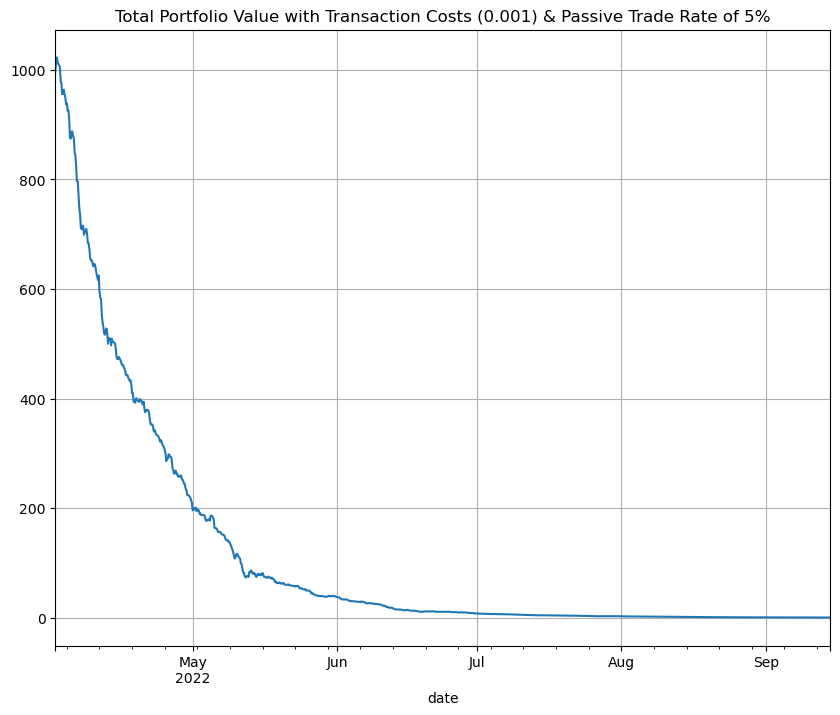

In [57]:
df_daily_portfolio_with_t_cost['total_portfolio_value'].plot(figsize=(10,8), grid=True, title='Total Portfolio Value with Transaction Costs (0.001) & Passive Trade Rate of 5%')

<Axes: title={'center': 'Available Cash with Transaction Costs (0.001) & Passive Trade Rate of 5%'}, xlabel='date'>

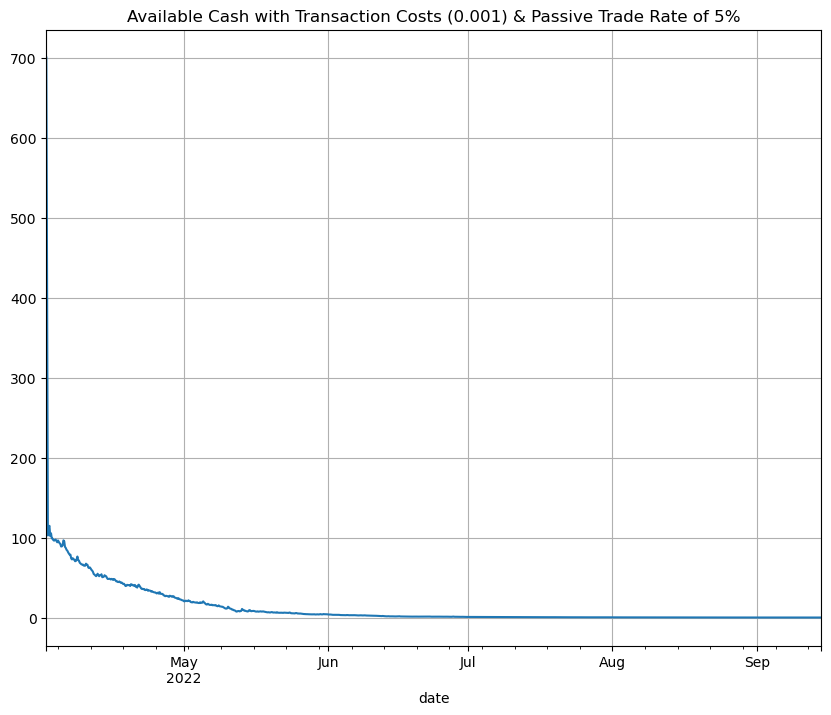

In [58]:
df_daily_portfolio_with_t_cost['available_cash'].plot(figsize=(10,8), grid=True, title='Available Cash with Transaction Costs (0.001) & Passive Trade Rate of 5%')

<Axes: title={'center': 'Turnover Plots with Transaction Costs (0.001) & Passive Trade Rate of 5%'}, xlabel='date'>

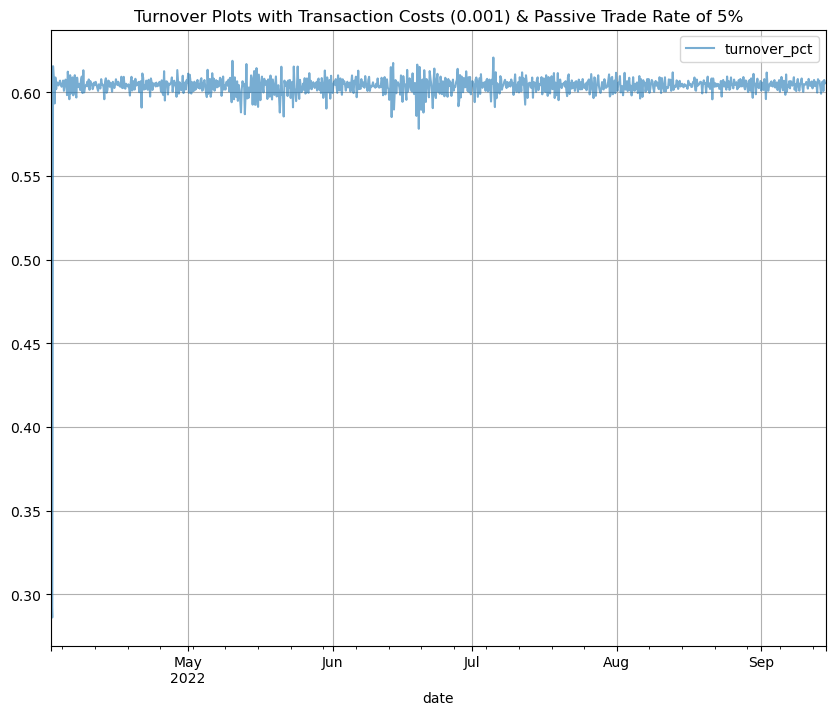

In [59]:
df_daily_portfolio_with_t_cost[['turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Turnover Plots with Transaction Costs (0.001) & Passive Trade Rate of 5%', alpha=0.6
)

<Axes: title={'center': 'Buy & Sell Turnover Plots with Transaction Costs (0.001) & Passive Trade Rate of 5%'}, xlabel='date'>

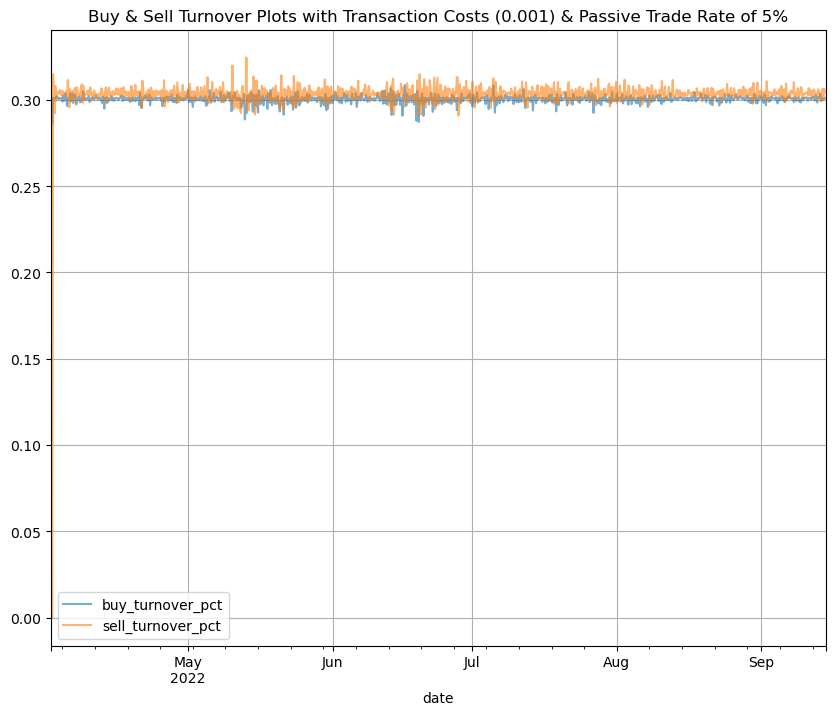

In [60]:
df_daily_portfolio_with_t_cost[['buy_turnover_pct','sell_turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Buy & Sell Turnover Plots with Transaction Costs (0.001) & Passive Trade Rate of 5%', alpha=0.6
)

<Axes: title={'center': 'Position Notional Transaction Costs (0.001) & Passive Trade Rate of 5%'}, xlabel='date'>

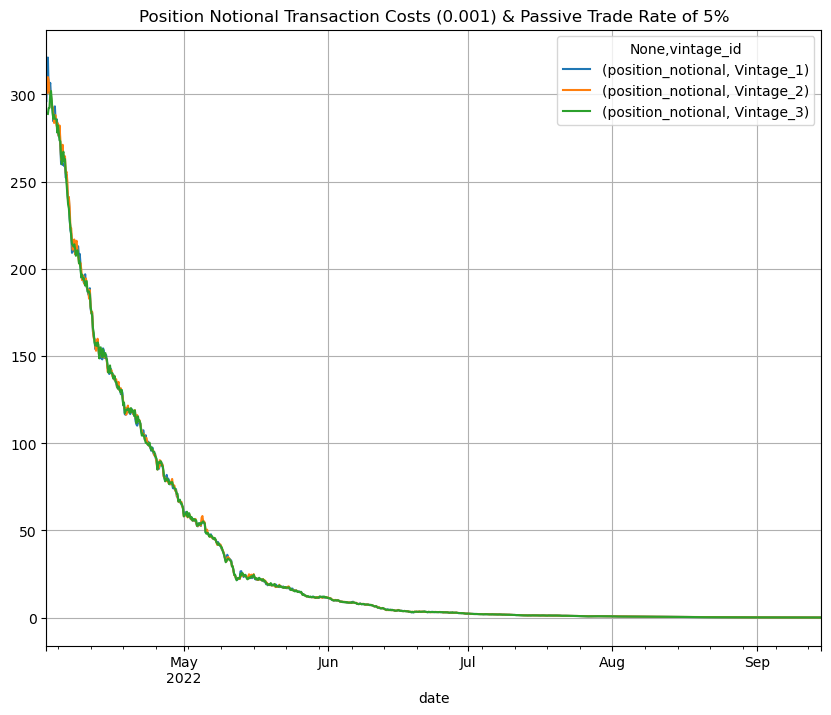

In [61]:
pd.pivot_table(df_daily_position_with_t_cost, index=['date'], columns=['vintage_id'], values=['position_notional'],
               aggfunc={'position_notional':'sum'}).plot(figsize=(10,8), grid=True, title='Position Notional Transaction Costs (0.001) & Passive Trade Rate of 5%')

In [62]:
pd.pivot_table(df_daily_position_with_t_cost, index=['date'], columns=['vintage_id'], values=['position_notional'],
               aggfunc={'position_notional':'sum'}).head(50)

position_notional                        
vintage_id                  Vintage_1   Vintage_2   Vintage_3
date                                                         
2022-04-01 12:00:00        296.190000         NaN         NaN
2022-04-01 16:00:00        316.140343  300.970608         NaN
2022-04-01 20:00:00        321.175940  309.954422  288.813952
2022-04-02 00:00:00        301.217993  308.338687  292.149070
2022-04-02 04:00:00        303.621621  300.592075  292.305452
2022-04-02 08:00:00        306.643411  300.119518  299.823039
2022-04-02 12:00:00        298.431031  299.425469  301.946618
2022-04-02 16:00:00        292.553198  292.714248  296.543795
2022-04-02 20:00:00        292.330805  293.196113  289.555987
2022-04-03 00:00:00        284.628118  288.148354  286.058259
2022-04-03 04:00:00        288.181398  283.655841  288.255926
2022-04-03 08:00:00        293.165590  287.915668  286.070354
2022-04-03 12:00:00        284.116978  288.075478  285.851421
2022-04-03 16:00:00        286.003025  282.500189  285.612384
2022-04-03 20:00:00        283.989428  280.937835  278.195395
2022-04-04 00:00:00        277.361410  283.370390  282.238978
2022-04-04 04:00:00        275.936363  276.240007  278.114761
2022-04-04 08:00:00        276.935880  282.218498  273.720724
2022-04-04 12:00:00        270.019320  274.266890  273.179859
2022-04-04 16:00:00        260.035198  262.573629  264.065663
2022-04-04 20:00:00        262.291284  263.230511  260.011129
2022-04-05 00:00:00        259.642360  271.135473  265.957452
2022-04-05 04:00:00        260.284898  263.498102  267.157281
2022-04-05 08:00:00        258.890370  263.174059  261.299017
2022-04-05 12:00:00        259.312809  264.571898  262.936299
2022-04-05 16:00:00        252.315430  254.846089  255.027500
2022-04-05 20:00:00        254.100922  255.702885  249.109691
2022-04-06 00:00:00        244.736461  250.370629  243.840457
2022-04-06 04:00:00        239.303629  238.975426  236.929817
2022-04-06 08:00:00        241.012648  241.154769  234.596933
2022-04-06 12:00:00        228.855962  235.229742  228.427876
2022-04-06 16:00:00        222.204537  223.925646  223.376614
2022-04-06 20:00:00        220.139350  223.367687  218.870059
2022-04-07 00:00:00        209.179799  216.351298  214.206517
2022-04-07 04:00:00        210.253199  210.984827  213.684205
2022-04-07 08:00:00        215.288031  214.887653  212.825027
2022-04-07 12:00:00        211.663969  216.829016  214.103572
2022-04-07 16:00:00        208.475529  208.514456  211.635601
2022-04-07 20:00:00        210.692513  214.999303  207.469865
2022-04-08 00:00:00        209.573253  216.109274  208.711408
2022-04-08 04:00:00        212.430261  210.464057  210.646177
2022-04-08 08:00:00        212.945245  207.573117  208.262587
2022-04-08 12:00:00        206.060730  203.890942  203.174222
2022-04-08 16:00:00        208.587954  202.549050  204.222477
2022-04-08 20:00:00        202.672572  203.383205  199.426117
2022-04-09 00:00:00        194.959388  199.565202  195.278679
2022-04-09 04:00:00        195.944373  193.537751  196.773709
2022-04-09 08:00:00        196.110849  196.249442  194.054413
2022-04-09 12:00:00        192.395225  195.679281  194.755757
2022-04-09 16:00:00        192.676763  191.354760  192.800595

In [63]:
## No Transaction Costs and Passive Trade Rate of 100%
df_daily_position_wo_t_cost_p_rate_100, df_daily_portfolio_wo_t_cost_p_rate_100 = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                              cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=0,
                                                                                                              passive_trade_rate=1, enable_fees=enable_fees)

0
100
200
300
400
500
600
700
800
900


<Axes: title={'center': 'Total Portfolio Value with No Transaction Costs & Passive Trade Rate of 100%'}, xlabel='date'>

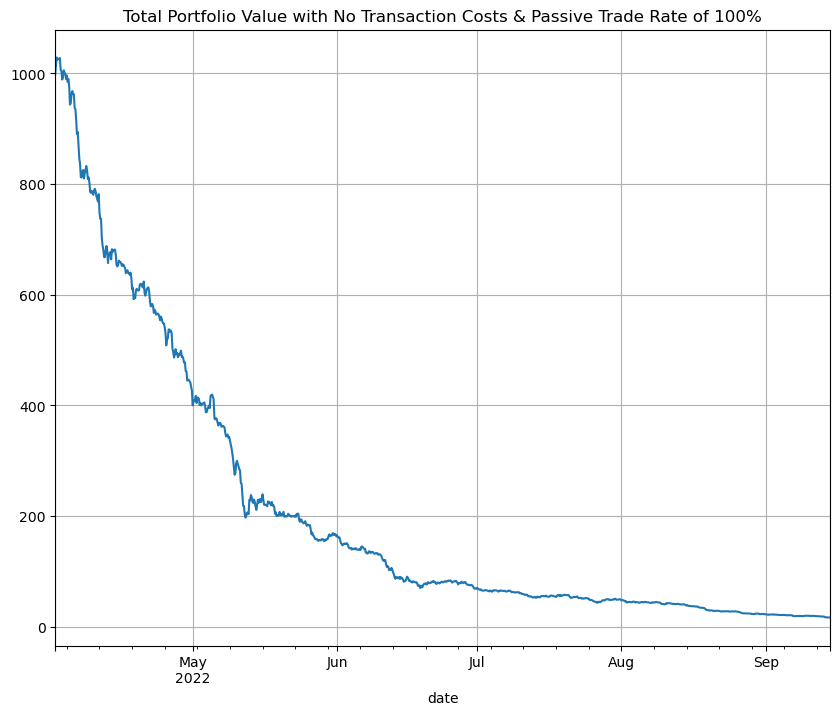

In [64]:
df_daily_portfolio_wo_t_cost_p_rate_100['total_portfolio_value'].plot(figsize=(10,8), grid=True, title='Total Portfolio Value with No Transaction Costs & Passive Trade Rate of 100%')

<Axes: title={'center': 'Available Cash Value with No Transaction Costs & Passive Trade Rate of 100%'}, xlabel='date'>

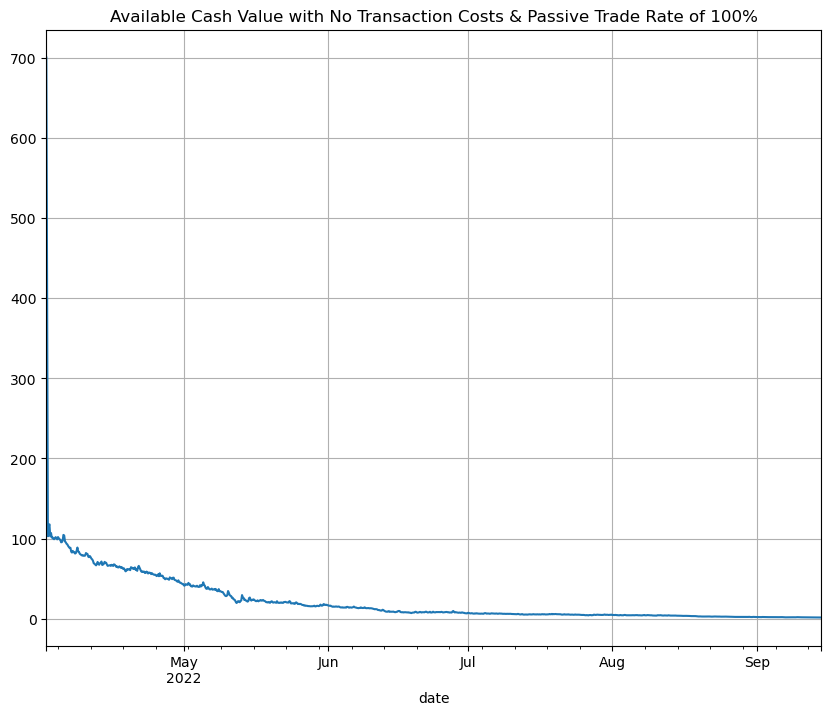

In [65]:
df_daily_portfolio_wo_t_cost_p_rate_100['available_cash'].plot(figsize=(10,8), grid=True, title='Available Cash Value with No Transaction Costs & Passive Trade Rate of 100%')

<Axes: title={'center': 'Turnover Plots with No Transaction Costs & Passive Trade Rate of 100%'}, xlabel='date'>

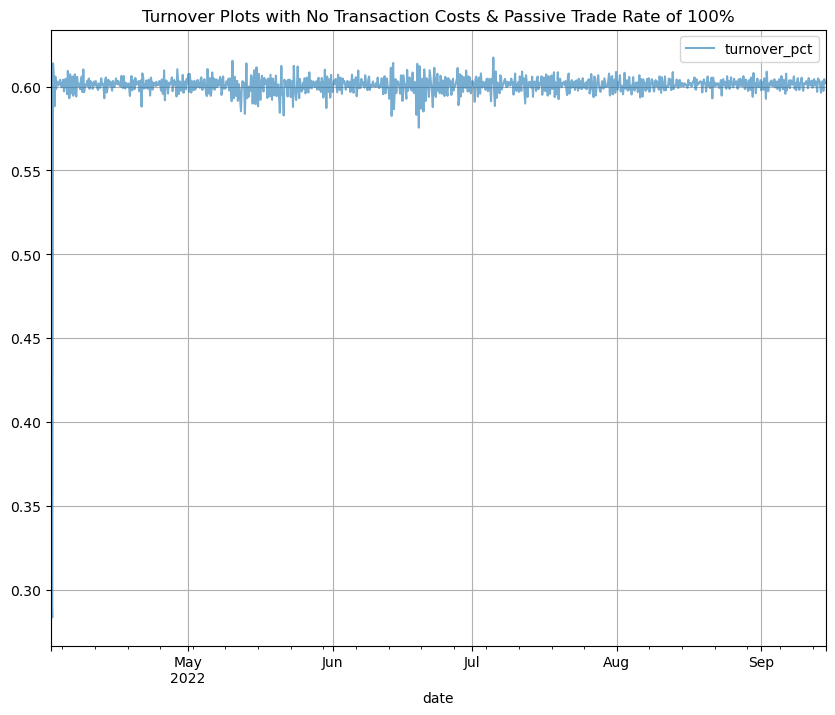

In [66]:
df_daily_portfolio_wo_t_cost_p_rate_100[['turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Turnover Plots with No Transaction Costs & Passive Trade Rate of 100%', alpha=0.6
)

<Axes: title={'center': 'Buy & Sell Turnover Plots with No Transaction Costs & Passive Trade Rate of 100%'}, xlabel='date'>

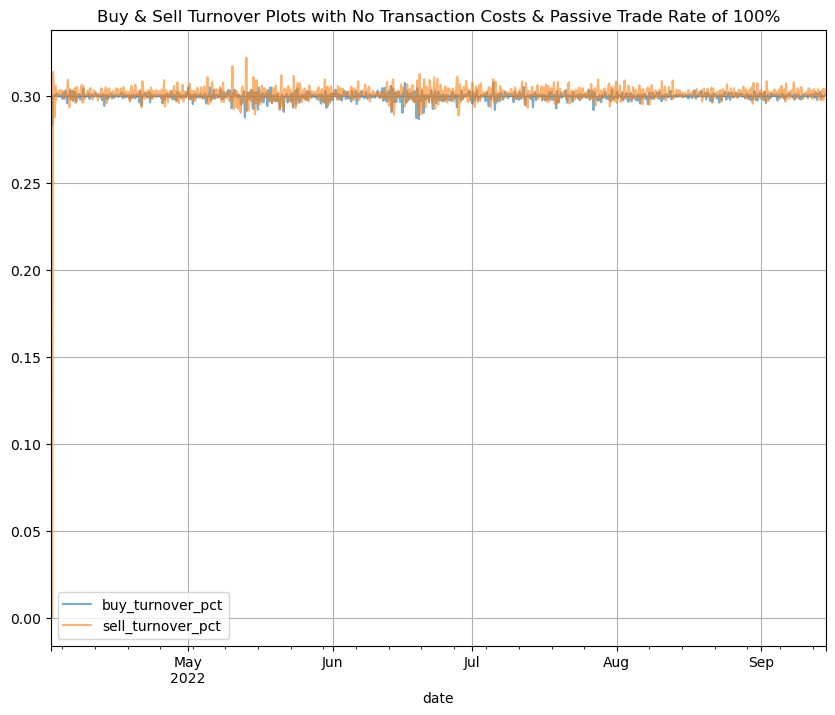

In [67]:
df_daily_portfolio_wo_t_cost_p_rate_100[['buy_turnover_pct','sell_turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Buy & Sell Turnover Plots with No Transaction Costs & Passive Trade Rate of 100%', alpha=0.6
)

<Axes: title={'center': 'Position Notional No Transaction Costs and Passive Trade Rate of 100%'}, xlabel='date'>

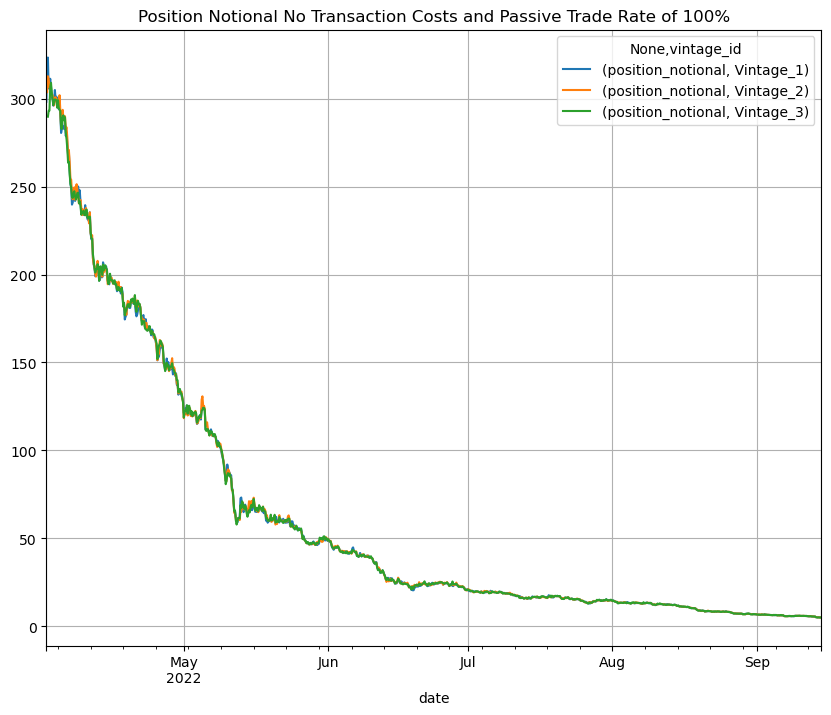

In [68]:
pd.pivot_table(df_daily_position_wo_t_cost_p_rate_100, index=['date'], columns=['vintage_id'], values=['position_notional'],
               aggfunc={'position_notional':'sum'}).plot(figsize=(10,8), grid=True, title='Position Notional No Transaction Costs and Passive Trade Rate of 100%')

In [69]:
pd.pivot_table(df_daily_position_wo_t_cost_p_rate_100, index=['date'], columns=['vintage_id'], values=['position_notional'],
               aggfunc={'position_notional':'sum'}).head(50)

position_notional                        
vintage_id                  Vintage_1   Vintage_2   Vintage_3
date                                                         
2022-04-01 12:00:00        298.200000         NaN         NaN
2022-04-01 16:00:00        318.285730  303.652805         NaN
2022-04-01 20:00:00        323.355499  312.716680  289.706901
2022-04-02 00:00:00        305.761838  311.086547  293.052331
2022-04-02 04:00:00        308.201724  306.364752  293.209196
2022-04-02 08:00:00        311.269097  305.883120  306.792212
2022-04-02 12:00:00        306.612983  305.175742  308.965152
2022-04-02 16:00:00        300.574000  301.523697  303.436744
2022-04-02 20:00:00        300.345510  302.020064  299.906313
2022-04-03 00:00:00        296.006192  296.820389  296.283557
2022-04-03 04:00:00        299.701515  296.147806  298.559780
2022-04-03 08:00:00        304.884951  300.595232  299.548593
2022-04-03 12:00:00        299.084456  300.762080  299.319344
2022-04-03 16:00:00        301.069861  298.590107  299.069044
2022-04-03 20:00:00        298.950186  296.938768  294.826045
2022-04-04 00:00:00        295.544195  299.509870  299.111356
2022-04-04 04:00:00        294.025728  295.537994  294.740591
2022-04-04 08:00:00        295.090769  301.934140  293.632296
2022-04-04 12:00:00        291.240756  293.427037  293.052086
2022-04-04 16:00:00        280.471959  284.342959  283.274886
2022-04-04 20:00:00        282.905356  285.054301  282.721163
2022-04-05 00:00:00        283.464646  293.614644  289.186853
2022-04-05 04:00:00        284.166137  288.844492  290.491478
2022-04-05 08:00:00        282.643661  288.489280  287.593633
2022-04-05 12:00:00        286.551653  290.021579  289.395675
2022-04-05 16:00:00        278.819252  282.749951  280.691011
2022-04-05 20:00:00        280.792297  283.700560  277.121677
2022-04-06 00:00:00        273.749695  277.784459  271.259926
2022-04-06 04:00:00        267.672807  268.377811  263.572197
2022-04-06 08:00:00        269.584428  270.825290  264.159992
2022-04-06 12:00:00        259.111566  264.171276  257.213533
2022-04-06 16:00:00        251.580798  254.543875  251.525730
2022-04-06 20:00:00        249.242586  253.909625  249.450496
2022-04-07 00:00:00        239.721994  245.933857  244.135367
2022-04-07 04:00:00        240.952120  242.760972  243.540078
2022-04-07 08:00:00        246.722085  247.251598  245.874064
2022-04-07 12:00:00        245.523976  249.485346  247.351150
2022-04-07 16:00:00        241.825479  242.513471  244.499935
2022-04-07 20:00:00        244.397115  250.055696  242.620775
2022-04-08 00:00:00        246.067497  251.346651  244.072669
2022-04-08 04:00:00        249.422013  248.124231  246.335239
2022-04-08 08:00:00        250.026674  244.715989  246.510647
2022-04-08 12:00:00        244.896747  240.374930  240.487788
2022-04-08 16:00:00        247.900273  241.353815  241.728558
2022-04-08 20:00:00        240.870027  242.347779  238.938062
2022-04-09 00:00:00        234.534360  237.798314  233.968899
2022-04-09 04:00:00        235.719287  233.765207  235.760137
2022-04-09 08:00:00        235.919556  237.040532  235.341990
2022-04-09 12:00:00        233.952893  236.351861  236.192553
2022-04-09 16:00:00        234.295243  233.954725  233.821405

In [70]:
## No Transaction Costs or Exchange Fees
df_daily_position_wo_t_cost_or_exch_fees, df_daily_portfolio_wo_t_cost_or_exch_fees = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                  cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=0,
                                                                                                                  passive_trade_rate=1.0, enable_fees=False)

0
100
200
300
400
500
600
700
800
900


<Axes: title={'center': 'Total Portfolio Value with No Transaction Costs or Exchange Fees'}, xlabel='date'>

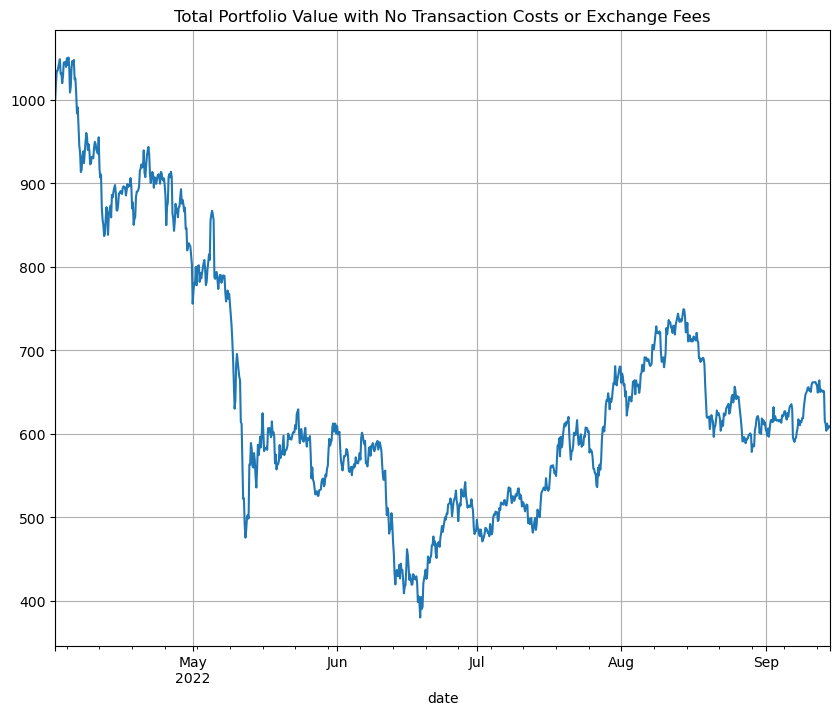

In [71]:
df_daily_portfolio_wo_t_cost_or_exch_fees['total_portfolio_value'].plot(figsize=(10,8), grid=True, title='Total Portfolio Value with No Transaction Costs or Exchange Fees')

<Axes: title={'center': 'Available Cash with No Transaction Costs or Exchange Fees'}, xlabel='date'>

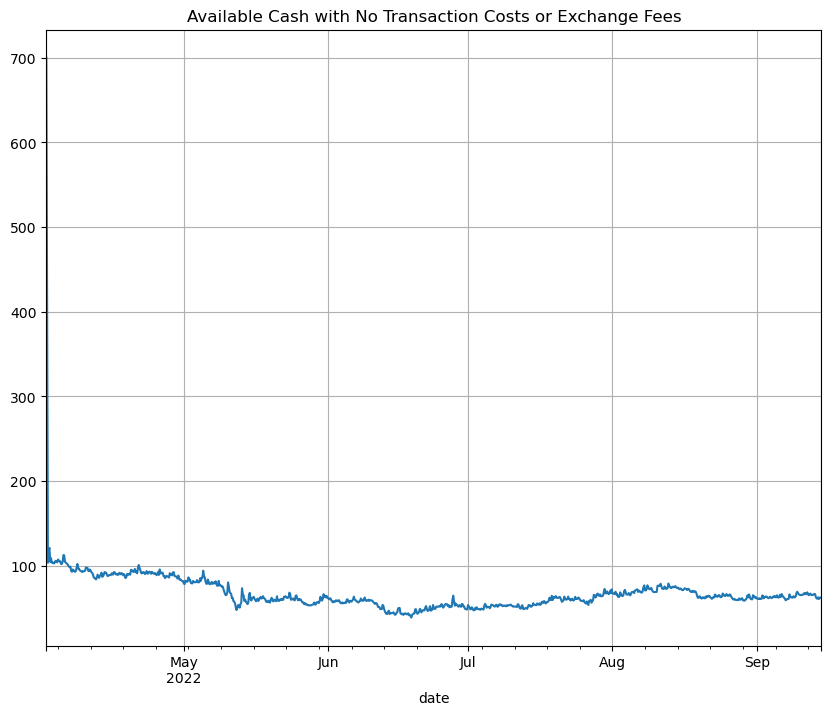

In [72]:
df_daily_portfolio_wo_t_cost_or_exch_fees['available_cash'].plot(figsize=(10,8), grid=True, title='Available Cash with No Transaction Costs or Exchange Fees')

<Axes: title={'center': 'Turnover Plots with No Transaction Costs or Exchange Fees'}, xlabel='date'>

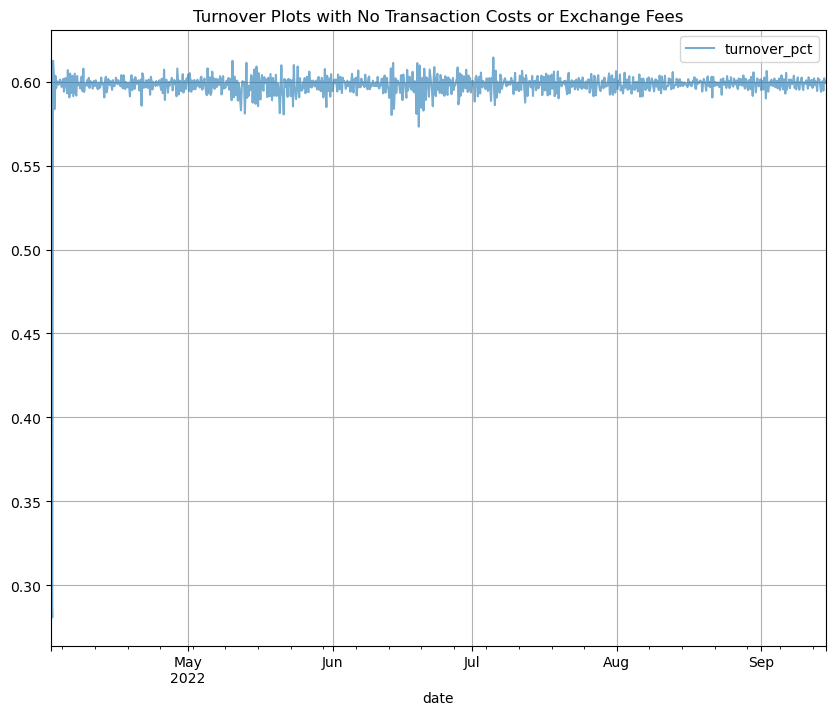

In [73]:
df_daily_portfolio_wo_t_cost_or_exch_fees[['turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Turnover Plots with No Transaction Costs or Exchange Fees', alpha=0.6
)

<Axes: title={'center': 'Buy & Sell Turnover Plots with No Transaction Costs or Exchange Fees'}, xlabel='date'>

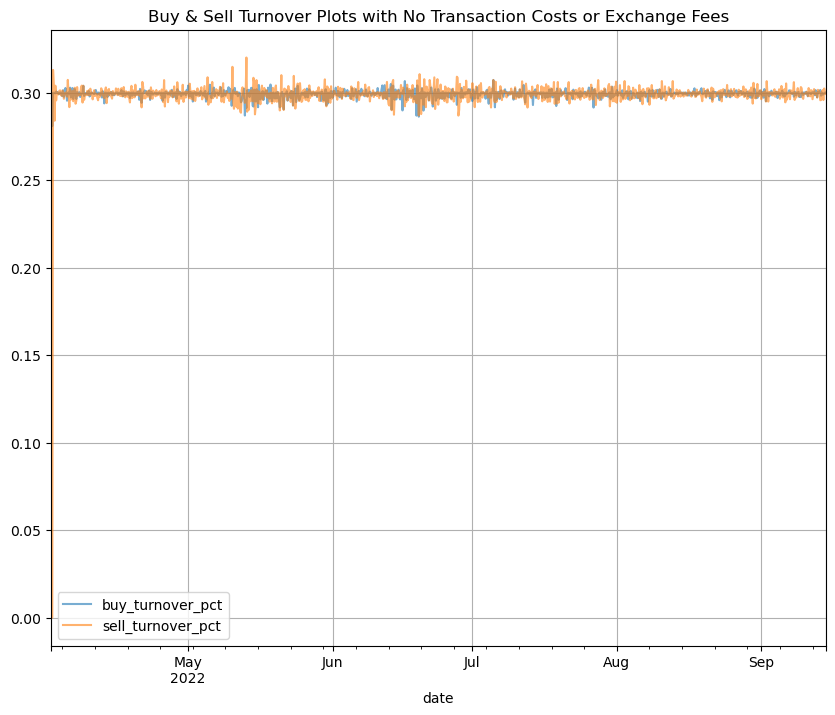

In [74]:
df_daily_portfolio_wo_t_cost_or_exch_fees[['buy_turnover_pct','sell_turnover_pct']].plot(
    figsize=(10,8), grid=True, title='Buy & Sell Turnover Plots with No Transaction Costs or Exchange Fees', alpha=0.6
)

<Axes: title={'center': 'Daily Position Value with No Transaction Costs or Exchange Fees'}, xlabel='date'>

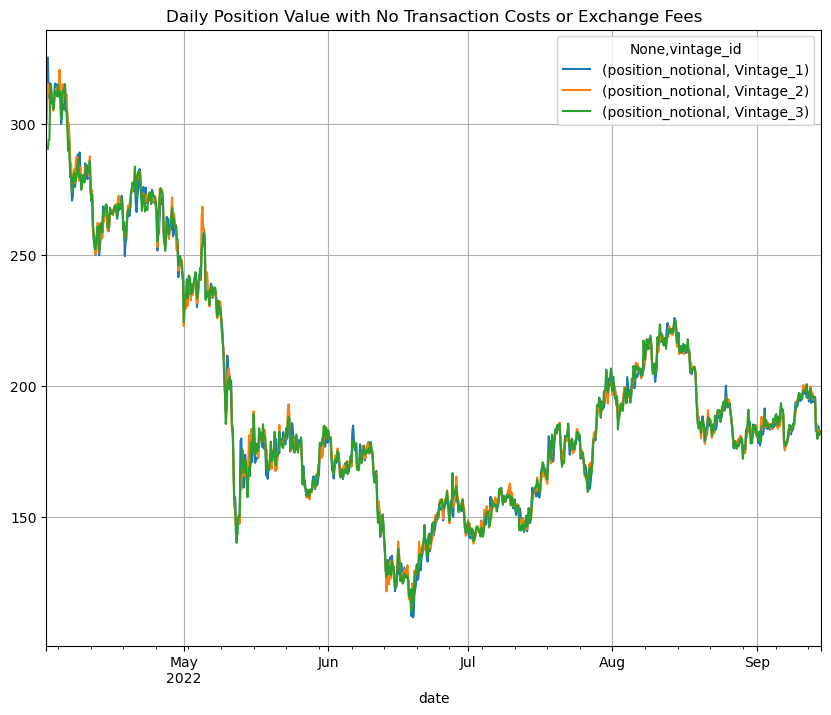

In [75]:
pd.pivot_table(df_daily_position_wo_t_cost_or_exch_fees, index=['date'], columns=['vintage_id'], values=['position_notional'],
               aggfunc={'position_notional':'sum'}).plot(figsize=(10,8), grid=True, title='Daily Position Value with No Transaction Costs or Exchange Fees')

<Axes: title={'center': 'Portfolio Value'}, xlabel='date'>

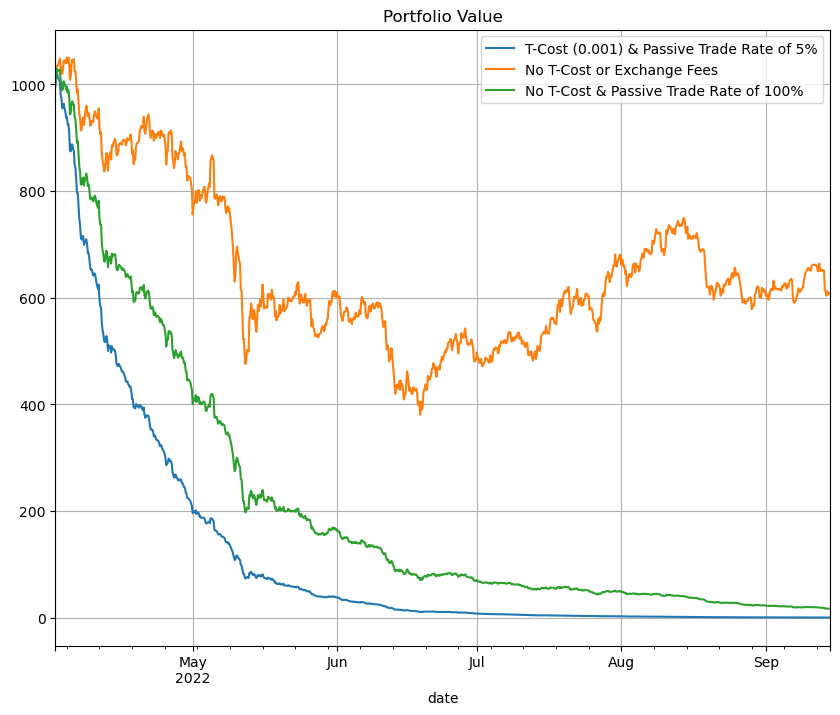

In [76]:
df_daily_portfolio_with_t_cost['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='T-Cost (0.001) & Passive Trade Rate of 5%', legend=True)
df_daily_portfolio_wo_t_cost_or_exch_fees['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='No T-Cost or Exchange Fees', legend=True)
df_daily_portfolio_wo_t_cost_p_rate_100['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='No T-Cost & Passive Trade Rate of 100%', title='Portfolio Value', legend=True)

<Axes: title={'center': 'Available Cash'}, xlabel='date'>

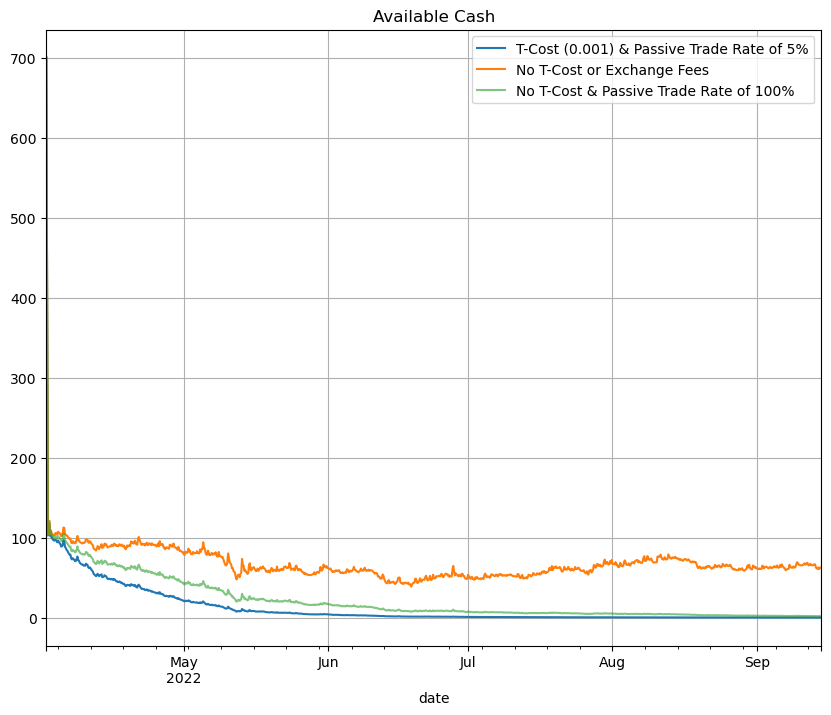

In [77]:
df_daily_portfolio_with_t_cost['available_cash'].plot(figsize=(10,8), grid=True, label='T-Cost (0.001) & Passive Trade Rate of 5%', legend=True)
df_daily_portfolio_wo_t_cost_or_exch_fees['available_cash'].plot(figsize=(10,8), grid=True, label='No T-Cost or Exchange Fees', legend=True)
df_daily_portfolio_wo_t_cost_p_rate_100['available_cash'].plot(figsize=(10,8), grid=True, label='No T-Cost & Passive Trade Rate of 100%', title='Available Cash', legend=True, alpha=0.6)

In [78]:
df_daily_portfolio_with_t_cost['daily_pct_returns'] = df_daily_portfolio_with_t_cost['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

{'annualized_return': -0.948469824807856,
 'annualized_sharpe_ratio': -8.364784629073064,
 'calmar_ratio': -0.9487457096985279,
 'annualized_std_dev': 0.3516775387197782,
 'max_drawdown': -0.9997092109214812,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2832832832832833,
 't_statistic': -13.601052630709516,
 'p_value': 8.947597001091062e-39,
 'trade_count': 999.0}

In [86]:
df_daily_portfolio_wo_t_cost_or_exch_fees['daily_pct_returns'] = df_daily_portfolio_wo_t_cost_or_exch_fees['total_portfolio_value'].pct_change()
df_daily_portfolio_wo_t_cost_or_exch_fees['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_wo_t_cost_or_exch_fees, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

{'annualized_return': -0.16562058125131585,
 'annualized_sharpe_ratio': -0.47161301730725985,
 'calmar_ratio': -0.25959621161160407,
 'annualized_std_dev': 0.354238217120147,
 'max_drawdown': -0.6379930593868209,
 'max_drawdown_duration': Timedelta('163 days 12:00:00'),
 'hit_rate': 0.5255255255255256,
 't_statistic': -0.5521888905767771,
 'p_value': 0.5809425786950844,
 'trade_count': 999.0}

In [87]:
df_daily_portfolio_wo_t_cost_p_rate_100['daily_pct_returns'] = df_daily_portfolio_wo_t_cost_p_rate_100['total_portfolio_value'].pct_change()
df_daily_portfolio_wo_t_cost_p_rate_100['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_wo_t_cost_p_rate_100, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

{'annualized_return': -0.7752396373297965,
 'annualized_sharpe_ratio': -4.182836414119039,
 'calmar_ratio': -0.7880959235063671,
 'annualized_std_dev': 0.3530164834646863,
 'max_drawdown': -0.9836869018185364,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.41041041041041043,
 't_statistic': -6.687963662929114,
 'p_value': 3.7624494849904406e-11,
 'trade_count': 999.0}

In [106]:
## Analyze the Qunitlie Performance by date for this signal
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

df_signal["quantile_bucket"] = df_signal.groupby("date", group_keys=False).apply(
    lambda g: cs_bucket(g, "close_log_return_z_score_prev_4h", q=5)
)

bucket_stats = (
    df_signal.dropna(subset=["quantile_bucket"])
    .groupby("quantile_bucket")["fwd_open_log_return_12h"]
    .agg(["mean", "std", "count"])
)
bucket_stats["t_stat"] = bucket_stats["mean"] / (bucket_stats["std"] / np.sqrt(bucket_stats["count"]))
## Denominator here is the Standard Error calculated as STD / sqrt(N). The t-stat calculates how many
## standard errors the observed mean is away from 0
## T-Stat assumes IID (which may not be the case) and n is large enough where the distribution is normal using Central Limit Theorem
bucket_stats


,mean,std,count,t_stat
quantile_bucket,,,,
0,0.000463,0.038325,48305,2.654359
1,0.000135,0.033470,48241,0.885081
2,-0.000100,0.032895,48206,-0.666324
3,-0.000347,0.033957,48148,-2.242080
4,-0.001576,0.043057,48140,-8.030642


In [108]:
df_signal[df_signal['date'] == pd.Timestamp('2022-04-01 12:00:00')].sort_values('quantile_bucket')

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec
174902,AAVE-USD,2022-04-01 12:00:00,214.000000,248.950000,220.440000,245.020000,6.893982e+04,False,-0.024246,-0.924200,0.104489,0,True,1.0,1.0
18096,ADA-USD,2022-04-01 12:00:00,1.117800,1.174900,1.131400,1.164200,2.231123e+07,False,-0.017172,-0.546004,0.030295,0,True,1.0,1.0
12065,SOL-USD,2022-04-01 12:00:00,122.140000,133.770000,124.410000,132.710000,6.450235e+05,False,-0.016341,-0.501548,0.078353,0,True,1.0,1.0
84437,SKL-USD,2022-04-01 12:00:00,0.249300,0.292200,0.260100,0.286800,3.022888e+07,False,-0.092860,-4.592921,0.151676,0,True,1.0,1.0
96499,LRC-USD,2022-04-01 12:00:00,1.131000,1.204500,1.152800,1.186300,7.242642e+06,False,-0.016943,-0.533743,0.029572,0,True,1.0,1.0
90468,IMX-USD,2022-04-01 12:00:00,2.266000,2.559000,2.305000,2.518000,1.002283e+06,False,-0.020133,-0.704334,0.080009,0,True,1.0,1.0
30158,DOT-USD,2022-04-01 12:00:00,20.630000,22.070000,21.080000,21.990000,2.527916e+05,False,-0.014592,-0.408033,0.045894,0,True,1.0,1.0
186964,COMP-USD,2022-04-01 12:00:00,143.040000,159.840000,146.110000,155.270000,1.877184e+04,False,-0.026548,-1.047287,0.083286,0,True,1.0,1.0
132685,GRT-USD,2022-04-01 12:00:00,0.447800,0.483800,0.456500,0.479100,9.485497e+06,False,-0.010681,-0.198937,0.060766,1,False,0.0,0.0
205057,SUSHI-USD,2022-04-01 12:00:00,4.260000,4.640000,4.370000,4.590000,1.021685e+06,False,-0.011403,-0.237505,0.031534,1,False,0.0,0.0


In [ ]:
df_daily_portfolio_wo_t_cost_or_exch_fees['daily_portfolio_pct_return'] = df_daily_portfolio_wo_t_cost_or_exch_fees['total_portfolio_value'].pct_change()

In [ ]:
df_daily_portfolio_wo_t_cost_or_exch_fees['daily_portfolio_pct_return'].describe()

In [ ]:
df_daily_portfolio_wo_t_cost_or_exch_fees.head()

In [ ]:
df_daily_portfolio_wo_t_cost_or_exch_fees.tail()

In [ ]:
df_daily_position_with_t_cost.iloc[0]

In [ ]:
df_daily_position_wo_t_cost_p_rate_100.iloc[0]

In [ ]:
df_daily_portfolio_wo_t_cost_or_exch_fees.iloc[0]

## Shadow Backtest

In [110]:
from collections import deque
import numpy as np
import pandas as pd

def run_mean_reversion_shadow_backtest(
    df_signal: pd.DataFrame,
    fwd_return_period: int,
    initial_capital: float,
    cash_buffer_percentage: float,
    transaction_cost_est: float,
    passive_trade_rate: float,
    enable_fees: bool,
    signal_col: str = "trade_signal_exec",
    max_periods: int | None = None,   # optional for debugging
):
    """
    Shadow engine:
    - No df_position, no holding counters, no vintages.
    - Uses cohort queue (each cohort is a dict ticker->shares) with fixed holding period H.
    - Trades at OPEN of each bar.
    - Buys are sized to ~ (PV*(1-buffer))/H each bar, constrained by deployable cash.
    - Cash reduced by GROSS buy notional; shares computed from NET (after fees).
    """

    df = df_signal.copy()
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["date", "ticker"]).reset_index(drop=True)

    periods = df["date"].drop_duplicates().tolist()
    if max_periods is not None:
        periods = periods[:max_periods]

    # Fee model (same form you use)
    est_fees = transaction_cost_est + estimate_fee_per_trade_w_enable_switch(
        passive_trade_rate=passive_trade_rate, enable_fees=enable_fees
    )

    # Price lookup: (date, ticker) -> open
    px = df.set_index(["date", "ticker"])["open"].astype(float)

    # Cohorts queue: each element is {"date": entry_date, "shares": pd.Series indexed by ticker}
    cohorts = deque()

    # Portfolio time series
    portfolio_cols = [
        "total_position_notional",
        "available_cash",
        "total_portfolio_value",
        "total_portfolio_value_upper_limit",
        "buy_notional_gross",
        "sell_notional_gross",
        "gross_traded_notional",
        "turnover_pct",
        "turnover_pct_half",
        "buy_turnover_pct",
        "sell_turnover_pct",
    ]
    df_port = pd.DataFrame(index=pd.Index(periods, name="date"), columns=portfolio_cols, dtype=float).fillna(0.0)

    cash = float(initial_capital)

    def mtm_positions_at(date_t) -> float:
        """Sum_{cohorts} sum_{ticker} shares * open_t"""
        if not cohorts:
            return 0.0
        total = 0.0
        for c in cohorts:
            sh = c["shares"]
            # align prices for tickers in this cohort
            p = px.loc[(date_t, sh.index)].values

            # prices_t = px.xs(date_t, level="date")  # open prices at this bar (from df_signal)
            # missing = sh.index.difference(prices_t.index)
            
            # if len(missing) > 0:
            #     print(date_t, "missing:", missing.tolist())

            total += float(np.dot(sh.values, p))
        return total

    def compute_gross_to_deploy(pv: float, cash: float) -> float:
        """Target invest per bar = PV*(1-buffer)/H, limited by deployable cash."""
        desired_cash = pv * cash_buffer_percentage
        deployable_cash = max(0.0, cash - desired_cash)
        target_per_bar = (pv * (1.0 - cash_buffer_percentage)) / float(fwd_return_period)
        return float(min(target_per_bar, deployable_cash))

    for t in periods[1:]:
        # print(t, cohorts)
        # --------------------
        # 1) MTM at open_t
        # --------------------
        pos_notional = mtm_positions_at(t)
        pv = cash + pos_notional

        # reset per-bar turnover
        buy_gross = 0.0
        sell_gross = 0.0

        # --------------------
        # 2) SELL expiring cohort (if we already have H cohorts)
        # --------------------
        if len(cohorts) >= fwd_return_period:
            exp = cohorts.popleft()
            sh = exp["shares"]
            p = px.loc[(t, sh.index)].values
            sell_gross = float(np.dot(sh.values, p))
            cash += sell_gross * (1.0 - est_fees)  # proceeds net of fees
            pos_notional -= sell_gross            # remove gross notional from holdings
            pv = cash + pos_notional

        # --------------------
        # 3) BUY new cohort
        # --------------------
        # picks at date t
        picks = df.loc[df["date"] == t].copy()
        picks = picks.loc[picks[signal_col].fillna(0).astype(float) != 0.0, ["ticker"]]

        if not picks.empty:
            gross_to_deploy = compute_gross_to_deploy(pv=pv, cash=cash)
            if gross_to_deploy > 0:
                n = len(picks)
                per_name_gross = gross_to_deploy / float(n)

                tickers = picks["ticker"].tolist()
                opens = px.loc[(t, tickers)].values

                # net notional after fees -> shares
                per_name_net = per_name_gross * (1.0 - est_fees)
                shares = per_name_net / opens

                cohort_shares = pd.Series(shares, index=pd.Index(tickers, name="ticker"), dtype=float)

                cohorts.append({"date": t, "shares": cohort_shares})

                buy_gross = gross_to_deploy
                cash -= buy_gross
                pos_notional += float(np.dot(cohort_shares.values, opens))  # equals per_name_net*n

                pv = cash + pos_notional

        # --------------------
        # 4) Write portfolio row + turnover
        # --------------------
        df_port.loc[t, "total_position_notional"] = pos_notional
        df_port.loc[t, "available_cash"] = cash
        df_port.loc[t, "total_portfolio_value"] = pv
        df_port.loc[t, "total_portfolio_value_upper_limit"] = pv * (1.0 - cash_buffer_percentage)

        df_port.loc[t, "buy_notional_gross"] = buy_gross
        df_port.loc[t, "sell_notional_gross"] = sell_gross
        df_port.loc[t, "gross_traded_notional"] = buy_gross + sell_gross

        if pv > 0:
            df_port.loc[t, "turnover_pct"] = (buy_gross + sell_gross) / pv
            df_port.loc[t, "turnover_pct_half"] = (buy_gross + sell_gross) / (2.0 * pv)
            df_port.loc[t, "buy_turnover_pct"] = buy_gross / pv
            df_port.loc[t, "sell_turnover_pct"] = sell_gross / pv

    return df_port


In [112]:
# Your current engine
df_pos_engine, df_port_engine = run_mean_reversion_backtest(
    df_signal=df_signal,
    fwd_return_period=3,
    initial_capital=1000,
    cash_buffer_percentage=0.10,
    transaction_cost_est=0.0,
    passive_trade_rate=1.0,
    enable_fees=False,
    signal_col="trade_signal_exec",
)

# Shadow engine (independent)
df_port_shadow = run_mean_reversion_shadow_backtest(
    df_signal=df_signal,
    fwd_return_period=3,
    initial_capital=1000,
    cash_buffer_percentage=0.10,
    transaction_cost_est=0.0,
    passive_trade_rate=1.0,
    enable_fees=False,
    signal_col="trade_signal_exec",
    max_periods=1000
)


0
100
200
300
400
500
600
700
800
900


In [113]:
cols = [
    "total_position_notional",
    "available_cash",
    "total_portfolio_value",
    "buy_notional_gross",
    "sell_notional_gross",
    "gross_traded_notional",
    "turnover_pct",
]

# Make sure both indexes are timestamps
df_port_engine = df_port_engine.copy()
df_port_engine.index = pd.to_datetime(df_port_engine.index)
df_port_shadow.index = pd.to_datetime(df_port_shadow.index)

recon = (
    df_port_engine[cols]
    .join(df_port_shadow[cols], how="inner", lsuffix="_engine", rsuffix="_shadow")
)

for c in cols:
    recon[f"{c}_diff"] = recon[f"{c}_engine"] - recon[f"{c}_shadow"]

# Quick diagnostics
print(recon[[f"{c}_diff" for c in cols]].abs().describe())


        total_position_notional_diff  available_cash_diff  \
count                          999.0                999.0   
unique                         998.0                998.0   
top                              0.0                  0.0   
freq                             2.0                  2.0   

        total_portfolio_value_diff  buy_notional_gross_diff  \
count                        999.0                    999.0   
unique                       997.0                    998.0   
top                            0.0                      0.0   
freq                           3.0                      2.0   

        sell_notional_gross_diff  gross_traded_notional_diff  \
count                      999.0                       999.0   
unique                     995.0                       998.0   
top                          0.0                         0.0   
freq                         5.0                         2.0   

        turnover_pct_diff  
count               999.0  
u

In [114]:
recon.head(20)

,total_position_notional_engine,available_cash_engine,total_portfolio_value_engine,buy_notional_gross_engine,sell_notional_gross_engine,gross_traded_notional_engine,turnover_pct_engine,total_position_notional_shadow,available_cash_shadow,total_portfolio_value_shadow,buy_notional_gross_shadow,sell_notional_gross_shadow,gross_traded_notional_shadow,turnover_pct_shadow,total_position_notional_diff,available_cash_diff,total_portfolio_value_diff,buy_notional_gross_diff,sell_notional_gross_diff,gross_traded_notional_diff,turnover_pct_diff
date,,,,,,,,,,,,,,,,,,,,,
2022-04-01 12:00:00,300.0,700.0,1000.0,300.0,0.0,300.0,0.3,300.000000,700.000000,1000.000000,300.000000,0.000000,300.000000,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-01 16:00:00,626.269064,393.937908,1020.206972,306.062092,0.0,306.062092,0.3,626.269064,393.937908,1020.206972,306.062092,0.000000,306.062092,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-01 20:00:00,930.998821,103.444313,1034.443135,290.493595,0.0,290.493595,0.280821,930.998821,103.444313,1034.443135,290.493595,0.000000,290.493595,0.280821,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
2022-04-02 00:00:00,917.268478,117.328146,1034.596624,309.865553,323.749385,633.614938,0.612427,917.781912,116.814712,1034.596624,310.378987,323.749385,634.128372,0.612923,-0.513434,0.513434,0.0,-0.513434,0.0,-0.513434,-0.000496
2022-04-02 04:00:00,917.944651,120.882856,1038.827507,311.601065,315.155775,626.75684,0.603331,918.510598,120.321006,1038.831604,311.649481,315.155775,626.805257,0.603375,-0.565948,0.561851,-0.004097,-0.048416,0.0,-0.048416,-0.000044
2022-04-02 08:00:00,939.389173,104.376575,1043.765747,312.831245,296.324963,609.156208,0.583614,939.397427,104.377492,1043.774919,312.268477,296.324963,608.593440,0.583070,-0.008254,-0.000917,-0.009172,0.562768,-0.0,0.562768,0.000544
2022-04-02 12:00:00,939.522226,108.919137,1048.441363,314.083536,318.626098,632.709634,0.603476,939.455676,108.996029,1048.451705,314.535512,319.154048,633.689560,0.604405,0.066549,-0.076891,-0.010342,-0.451976,-0.52795,-0.979926,-0.000929
2022-04-02 16:00:00,927.19585,103.64812,1030.843971,309.88871,304.617693,614.506403,0.59612,926.449998,104.404656,1030.854655,309.256396,304.665024,613.921421,0.595546,0.745852,-0.756536,-0.010684,0.632314,-0.047331,0.584982,0.000574
2022-04-02 20:00:00,927.493288,103.943655,1031.436943,309.431083,309.726617,619.1577,0.600287,927.305291,104.140388,1031.445679,309.433704,309.169435,618.603139,0.599744,0.187997,-0.196733,-0.008736,-0.002621,0.557183,0.554562,0.000543


<Axes: title={'center': 'Total Position Notional'}, xlabel='date'>

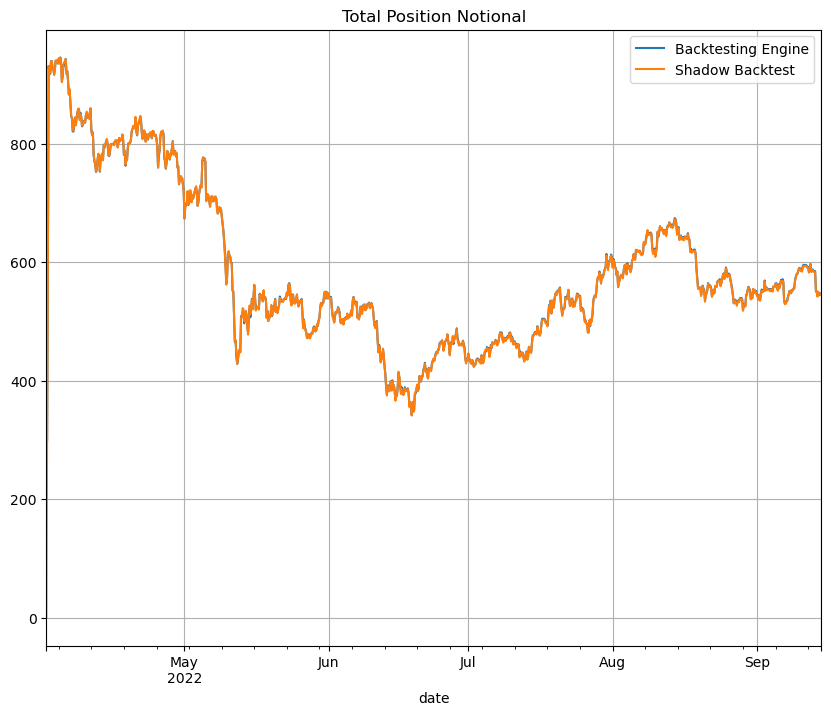

In [115]:
df_port_engine['total_position_notional'].plot(figsize=(10,8), grid=True, label='Backtesting Engine', legend=True)
df_port_shadow['total_position_notional'].plot(figsize=(10,8), grid=True, label='Shadow Backtest', legend=True, title='Total Position Notional')

<Axes: title={'center': 'Available Cash'}, xlabel='date'>

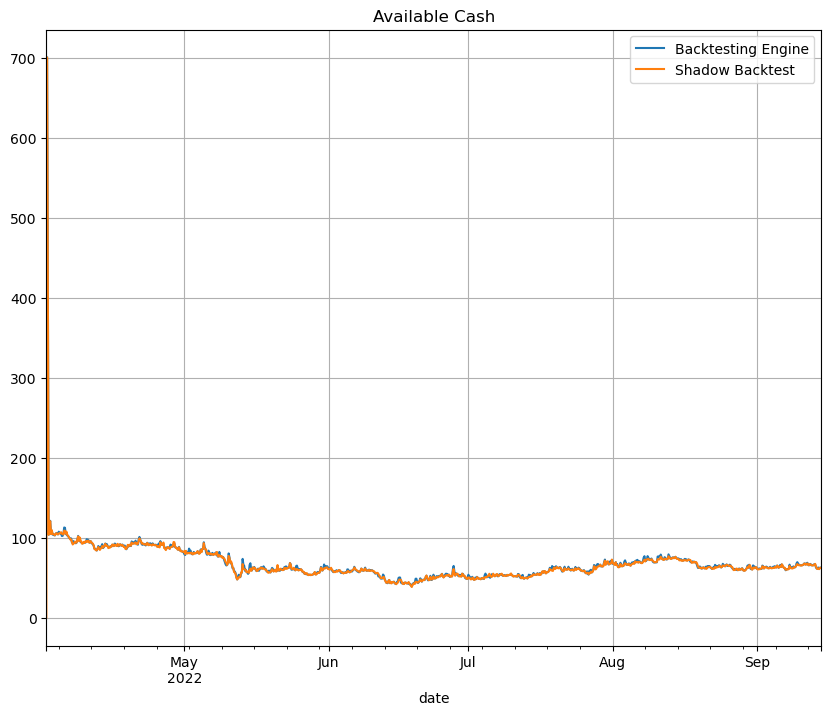

In [116]:
df_port_engine['available_cash'].plot(figsize=(10,8), grid=True, label='Backtesting Engine', legend=True)
df_port_shadow['available_cash'].plot(figsize=(10,8), grid=True, label='Shadow Backtest', legend=True, title='Available Cash')

<Axes: title={'center': 'Total Portfolio Value'}, xlabel='date'>

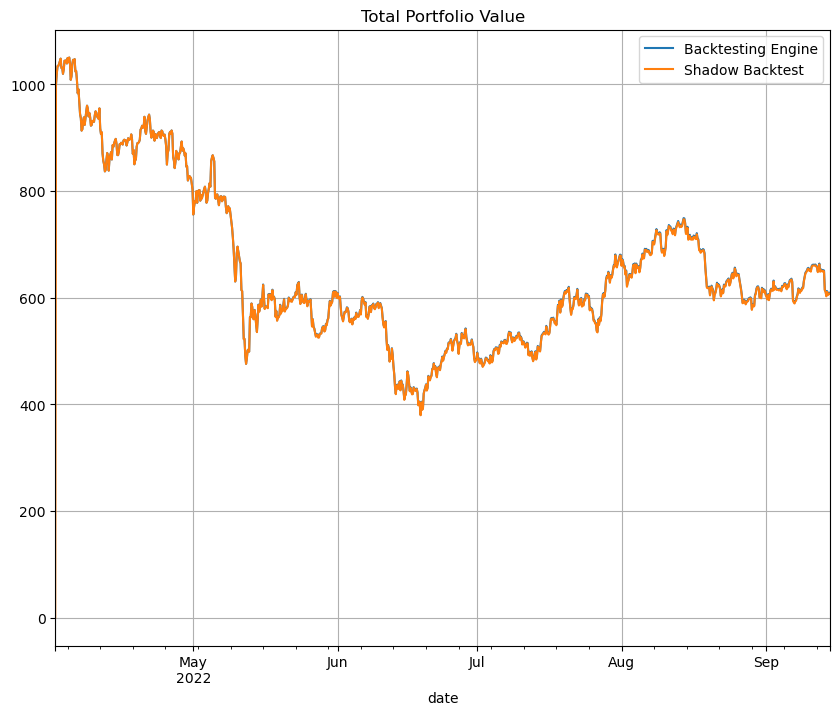

In [117]:
df_port_engine['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Backtesting Engine', legend=True)
df_port_shadow['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Shadow Backtest', legend=True, title='Total Portfolio Value')

In [120]:
df_port_engine['daily_pct_returns'] = df_port_engine['total_portfolio_value'].pct_change()
df_port_engine['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_port_engine, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

{'annualized_return': -0.16562058125131585,
 'annualized_sharpe_ratio': -0.47161301730725985,
 'calmar_ratio': -0.25959621161160407,
 'annualized_std_dev': 0.354238217120147,
 'max_drawdown': -0.6379930593868209,
 'max_drawdown_duration': Timedelta('163 days 12:00:00'),
 'hit_rate': 0.5255255255255256,
 't_statistic': -0.5521888905767771,
 'p_value': 0.5809425786950844,
 'trade_count': 999.0}

In [121]:
df_port_engine.head()

,total_position_notional,available_cash,total_portfolio_value,total_portfolio_value_upper_limit,buy_notional_gross,sell_notional_gross,gross_traded_notional,turnover_pct,turnover_pct_half,buy_turnover_pct,sell_turnover_pct,daily_pct_returns,count_of_trades,strategy_cumulative_return,equity_curve,equity_curve_cum_max,drawdown,drawdown_pct,End,Start,equity_curve_DDDuration,profitable_trade
date,,,,,,,,,,,,,,,,,,,,,,
2022-04-01 12:00:00,300.000000,700.000000,1000.000000,900.000000,300.000000,0.000000,300.000000,0.300000,0.150000,0.300000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.0,0.0,2022-04-01 12:00:00,1,0 days,False
2022-04-01 16:00:00,626.269064,393.937908,1020.206972,918.186275,306.062092,0.000000,306.062092,0.300000,0.150000,0.300000,0.000000,0.020207,1.0,0.020207,1.020207,1.020207,0.0,0.0,2022-04-01 16:00:00,2,0 days,True
2022-04-01 20:00:00,930.998821,103.444313,1034.443135,930.998821,290.493595,0.000000,290.493595,0.280821,0.140411,0.280821,0.000000,0.013954,1.0,0.034443,1.034443,1.034443,0.0,0.0,2022-04-01 20:00:00,3,0 days,True
2022-04-02 00:00:00,917.268478,117.328146,1034.596624,931.136961,309.865553,323.749385,633.614938,0.612427,0.306214,0.299504,0.312923,0.000148,1.0,0.034597,1.034597,1.034597,0.0,0.0,2022-04-02 00:00:00,4,0 days,True
2022-04-02 04:00:00,917.944651,120.882856,1038.827507,934.944756,311.601065,315.155775,626.756840,0.603331,0.301666,0.299955,0.303376,0.004089,1.0,0.038828,1.038828,1.038828,0.0,0.0,2022-04-02 04:00:00,5,0 days,True


In [122]:
df_port_shadow['daily_pct_returns'] = df_port_shadow['total_portfolio_value'].pct_change()
df_port_shadow['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_port_shadow, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

{'annualized_return': inf,
 'annualized_sharpe_ratio': nan,
 'calmar_ratio': inf,
 'annualized_std_dev': 0.3540262883682945,
 'max_drawdown': -0.6387956632229747,
 'max_drawdown_duration': Timedelta('163 days 12:00:00'),
 'hit_rate': 0.525,
 't_statistic': -0.5562688520167929,
 'p_value': 0.5781516487275584,
 'trade_count': 1000.0}

In [959]:
df_port_engine['pv_check'] = (df_port_engine['total_position_notional'] + df_port_engine['available_cash']) - df_port_engine['total_portfolio_value']

<Axes: xlabel='date'>

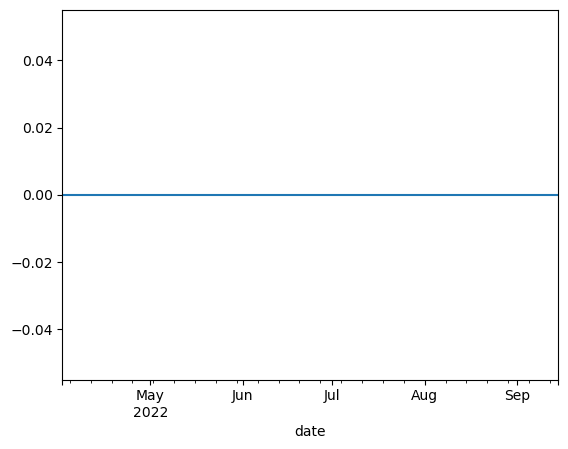

In [961]:
df_port_engine['pv_check'].plot()

<Axes: xlabel='date'>

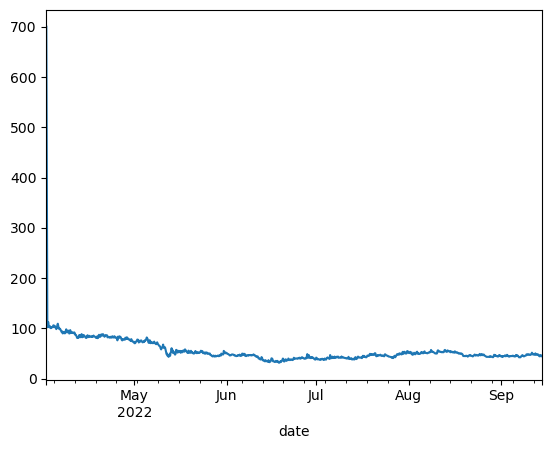

In [963]:
df_port_engine['available_cash'].plot()

In [957]:
df_port_engine.head()

,total_position_notional,available_cash,total_portfolio_value,total_portfolio_value_upper_limit,buy_notional_gross,sell_notional_gross,gross_traded_notional,turnover_pct,turnover_pct_half,buy_turnover_pct,sell_turnover_pct,daily_pct_returns,count_of_trades,strategy_cumulative_return,equity_curve,equity_curve_cum_max,drawdown,drawdown_pct,End,Start,equity_curve_DDDuration,profitable_trade
date,,,,,,,,,,,,,,,,,,,,,,
2022-04-01 12:00:00,300.000000,700.000000,1000.000000,900.000000,300.000000,0.000000,300.000000,0.300000,0.150000,0.300000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,2022-04-01 12:00:00,1,0 days 00:00:00,False
2022-04-01 16:00:00,610.460477,397.586044,1008.046521,907.241869,302.413956,0.000000,302.413956,0.300000,0.150000,0.300000,0.000000,0.008047,0.0,0.008047,1.008047,1.008047,0.000000,0.000000,2022-04-01 16:00:00,2,0 days 00:00:00,True
2022-04-01 20:00:00,919.276607,102.141845,1021.418452,919.276607,295.444198,0.000000,295.444198,0.289249,0.144624,0.289249,0.000000,0.013265,0.0,0.021418,1.021418,1.021418,0.000000,0.000000,2022-04-01 20:00:00,3,0 days 08:00:00,True
2022-04-02 00:00:00,905.591430,111.274137,1016.865567,915.179011,305.963696,315.095988,621.059684,0.610759,0.305379,0.300889,0.309870,-0.004457,0.0,0.016866,1.016866,1.021418,-0.004553,-0.004457,2022-04-02 00:00:00,3,0 days 08:00:00,False
2022-04-02 04:00:00,906.989970,112.004156,1018.994126,917.094713,305.236406,305.966424,611.202830,0.599810,0.299905,0.299547,0.300263,0.002093,0.0,0.018994,1.018994,1.021418,-0.002424,-0.002373,2022-04-02 04:00:00,3,0 days 08:00:00,True


## Analyzing Signal Construction

In [132]:
def calculate_z_score(df, return_col, date_col, z_score_col_name):

    return_mean = df.groupby([date_col])[return_col].transform('mean')
    return_std = df.groupby([date_col])[return_col].transform('std').replace(0, np.nan)
    df[z_score_col_name] = (df[return_col] - return_mean) / return_std

    return df
    

def build_return_features(df, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50):

    df_returns = df.copy()

    ## Get Previous 4 hour returns
    ticker_group_close = df_returns.groupby(['ticker'])['close']
    df_returns['close_log_return_prev_4h'] = np.log(ticker_group_close.shift(1) / ticker_group_close.shift(2))

    ## Require a minimum number of tickers to calculate Z-Score for a given bar
    ticker_count_by_date = df_returns.groupby(['date'])['ticker'].transform('nunique')
    df_returns = df_returns[ticker_count_by_date >= min_z_score_ticker_count]

    ## Calculate cross-sectional Z-Score across all tickers per bar
    df_returns = calculate_z_score(df_returns, return_col='close_log_return_prev_4h', date_col='date', z_score_col_name='close_log_return_z_score_prev_4h')

    ## Get forward return for specified period (Open(T) to Open(T+H))
    df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = np.log(df_returns.groupby(['ticker'])['open'].shift(-fwd_return_period) / df_returns['open'])

    ## Winsorize Forward Return to reduce data glitches
    if winsorize_fwd_return:
        df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'].clip(-fwd_return_cap, fwd_return_cap)

    return df_returns

def build_return_features_returns_demean(df, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50):

    df_returns = df.copy()

    ## Get Previous 4 hour returns
    ticker_group_close = df_returns.groupby(['ticker'])['close']
    df_returns['close_log_return_prev_4h'] = np.log(ticker_group_close.shift(1) / ticker_group_close.shift(2))

    ## Demean Returns using the Daily Mean Return across all Coins
    df_returns["ret_prev_cs_demean"] = df_returns["close_log_return_prev_4h"] - df_returns.groupby("date")["close_log_return_prev_4h"].transform("mean")

    ## Require a minimum number of tickers to calculate Z-Score for a given bar
    ticker_count_by_date = df_returns.groupby(['date'])['ticker'].transform('nunique')
    df_returns = df_returns[ticker_count_by_date >= min_z_score_ticker_count]

    ## Calculate cross-sectional Z-Score across all tickers per bar
    df_returns = calculate_z_score(df_returns, return_col='ret_prev_cs_demean', date_col='date', z_score_col_name='close_log_return_z_score_prev_4h_demean')

    ## Get forward return for specified period (Open(T) to Open(T+H))
    df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = np.log(df_returns.groupby(['ticker'])['open'].shift(-fwd_return_period) / df_returns['open'])

    ## Winsorize Forward Return to reduce data glitches
    if winsorize_fwd_return:
        df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'].clip(-fwd_return_cap, fwd_return_cap)

    return df_returns

In [247]:
df_returns = build_return_features(df_ticker_price_impute, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50)
return_cols = ['close_log_return_prev_4h','fwd_open_log_return_12h']
df_signal = df_returns.dropna(subset=return_cols).copy()

## Demeaning Coin Returns with Mean Return for the Day
df_returns_demean = build_return_features_returns_demean(df_ticker_price_impute, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50)
return_cols = ['close_log_return_prev_4h','fwd_open_log_return_12h']
df_signal_demean = df_returns_demean.dropna(subset=return_cols).copy()

## Break the Z-Scores per period into Deciles
# def cs_bucket(group, col, q=10):
#     # cross-sectional bucketing within each timestamp
#     return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

# df_signal["quantile_bucket"] = df_signal.groupby("date", group_keys=False).apply(
#     lambda g: cs_bucket(g, "close_log_return_z_score_prev_4h", q=10)
# )

# ## Identify bottom performing tickers per period
# q = 0.2  # bottom 20%
# df_signal["bottom_quintile_signal"] = df_signal.groupby("date")["close_log_return_z_score_prev_4h"].transform(
#     lambda s: s <= s.quantile(q)
# )

# # compute signal on bar close, execute next bar open
# df_signal = df_signal.sort_values(["ticker", "date"])
# df_signal["trade_signal"] = df_signal["bottom_quintile_signal"].astype(float)
# # df_signal["trade_signal_exec"] = df_signal.groupby("ticker")["trade_signal"].shift(1).fillna(0.0)
# df_signal["trade_signal_exec"] = df_signal.groupby("ticker")["trade_signal"].fillna(0.0)

# # then use trade_signal_exec (not trade_signal) in open_new_vintage_positions


In [255]:
daily_mean = df_signal[df_signal['date'] == pd.Timestamp('2022-04-01 16:00:00')]['close_log_return_prev_4h'].mean()
daily_std = df_signal[df_signal['date'] == pd.Timestamp('2022-04-01 16:00:00')]['close_log_return_prev_4h'].std()

In [267]:
print(daily_mean, daily_std)

0.03970420433127071 0.02161694799565086


In [257]:
(0.031928 - daily_mean) / daily_std

-0.3597272072281072

In [249]:
df_signal[df_signal['date'] == pd.Timestamp('2022-04-01 16:00:00')]#.head()

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h
4,BTC-USD,2022-04-01 16:00:00,45906.000000,46607.890000,46545.310000,46390.690000,3.498550e+03,False,0.031928,-0.359704,0.001520
6035,ETH-USD,2022-04-01 16:00:00,3406.060000,3482.420000,3432.490000,3471.130000,4.725017e+04,False,0.043721,0.185812,0.012637
12066,SOL-USD,2022-04-01 16:00:00,132.150000,137.690000,132.720000,137.510000,4.843748e+05,False,0.064423,1.143491,0.015476
18097,ADA-USD,2022-04-01 16:00:00,1.153600,1.175000,1.164000,1.173400,1.230750e+07,False,0.028402,-0.522859,0.013483
24128,AVAX-USD,2022-04-01 16:00:00,96.740000,99.820000,96.750000,99.140000,3.711515e+05,False,0.040168,0.021443,0.007722
30159,DOT-USD,2022-04-01 16:00:00,21.700000,22.110000,21.980000,22.020000,1.855854e+05,False,0.041789,0.096434,0.014454
36190,ATOM-USD,2022-04-01 16:00:00,29.050000,29.700000,29.370000,29.600000,2.186262e+05,False,0.035006,-0.217331,0.018219
42221,LTC-USD,2022-04-01 16:00:00,123.730000,126.290000,124.860000,126.290000,4.864883e+04,False,0.021285,-0.852066,0.011863
48252,ALGO-USD,2022-04-01 16:00:00,0.934500,0.980000,0.947500,0.941900,5.879213e+06,False,0.026848,-0.594729,0.014147
54283,XLM-USD,2022-04-01 16:00:00,0.228913,0.232299,0.231283,0.231680,1.352189e+07,False,0.026847,-0.594794,0.019189


In [261]:
daily_demean_mean = df_signal_demean[df_signal_demean['date'] == pd.Timestamp('2022-04-01 16:00:00')]['ret_prev_cs_demean'].mean()
daily_demean_std = df_signal_demean[df_signal_demean['date'] == pd.Timestamp('2022-04-01 16:00:00')]['ret_prev_cs_demean'].std()

In [263]:
daily_demean_mean

-4.163336342344337e-18

In [265]:
daily_demean_std

0.021616947995650858

In [269]:
(-0.007776 - daily_demean_mean) / daily_demean_std

-0.3597177548636588

In [251]:
df_signal_demean[df_signal_demean['date'] == pd.Timestamp('2022-04-01 16:00:00')]#.head()

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,ret_prev_cs_demean,close_log_return_z_score_prev_4h_demean,fwd_open_log_return_12h
4,BTC-USD,2022-04-01 16:00:00,45906.000000,46607.890000,46545.310000,46390.690000,3.498550e+03,False,0.031928,-0.007776,-0.359704,0.001520
6035,ETH-USD,2022-04-01 16:00:00,3406.060000,3482.420000,3432.490000,3471.130000,4.725017e+04,False,0.043721,0.004017,0.185812,0.012637
12066,SOL-USD,2022-04-01 16:00:00,132.150000,137.690000,132.720000,137.510000,4.843748e+05,False,0.064423,0.024719,1.143491,0.015476
18097,ADA-USD,2022-04-01 16:00:00,1.153600,1.175000,1.164000,1.173400,1.230750e+07,False,0.028402,-0.011303,-0.522859,0.013483
24128,AVAX-USD,2022-04-01 16:00:00,96.740000,99.820000,96.750000,99.140000,3.711515e+05,False,0.040168,0.000464,0.021443,0.007722
30159,DOT-USD,2022-04-01 16:00:00,21.700000,22.110000,21.980000,22.020000,1.855854e+05,False,0.041789,0.002085,0.096434,0.014454
36190,ATOM-USD,2022-04-01 16:00:00,29.050000,29.700000,29.370000,29.600000,2.186262e+05,False,0.035006,-0.004698,-0.217331,0.018219
42221,LTC-USD,2022-04-01 16:00:00,123.730000,126.290000,124.860000,126.290000,4.864883e+04,False,0.021285,-0.018419,-0.852066,0.011863
48252,ALGO-USD,2022-04-01 16:00:00,0.934500,0.980000,0.947500,0.941900,5.879213e+06,False,0.026848,-0.012856,-0.594729,0.014147
54283,XLM-USD,2022-04-01 16:00:00,0.228913,0.232299,0.231283,0.231680,1.352189e+07,False,0.026847,-0.012858,-0.594794,0.019189


In [231]:
## Strategy Params
initial_capital = 1000
cash_buffer_percentage = 0.10
fwd_return_period = 3
transaction_cost_est = 0.001
passive_trade_rate = 0.05
enable_fees = True

In [211]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost, df_daily_portfolio_with_t_cost = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                            cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                            passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec')

df_daily_portfolio_with_t_cost['daily_pct_returns'] = df_daily_portfolio_with_t_cost['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.948469824807856,
 'annualized_sharpe_ratio': -8.364784629073064,
 'calmar_ratio': -0.9487457096985279,
 'annualized_std_dev': 0.3516775387197782,
 'max_drawdown': -0.9997092109214812,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2832832832832833,
 't_statistic': -13.601052630709516,
 'p_value': 8.947597001091062e-39,
 'trade_count': 999.0}

In [185]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost, df_daily_portfolio_with_t_cost = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                            cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                            passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec')

df_daily_portfolio_with_t_cost['daily_pct_returns'] = df_daily_portfolio_with_t_cost['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost['count_of_trades'] = 0.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.9541523968203758,
 'annualized_sharpe_ratio': -8.758730903446653,
 'calmar_ratio': -0.954356521671956,
 'annualized_std_dev': nan,
 'max_drawdown': -0.9997861125827248,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2752752752752753,
 't_statistic': -14.25064082325529,
 'p_value': 4.4229860259808124e-42,
 'trade_count': 0.0}

In [233]:
## Backtest with Transaction Costs and Passive Trade Rate of 5% After Demeaning Returns
df_daily_position_with_t_cost_returns_demean, df_daily_portfolio_with_t_cost_returns_demean = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                          cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                          passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec')

df_daily_portfolio_with_t_cost_returns_demean['daily_pct_returns'] = df_daily_portfolio_with_t_cost_returns_demean['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_returns_demean['count_of_trades'] = 0.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_returns_demean, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.948469824807856,
 'annualized_sharpe_ratio': -8.364784629073064,
 'calmar_ratio': -0.9487457096985279,
 'annualized_std_dev': nan,
 'max_drawdown': -0.9997092109214812,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2832832832832833,
 't_statistic': -13.601052630709516,
 'p_value': 8.947597001091062e-39,
 'trade_count': 0.0}

In [187]:
df_daily_position_with_t_cost.head()

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec,position_weight,position_notional,position_size,holding_period_counter,vintage_id,trade_notional_gross
0,AIOZ-USD,2022-04-01 12:00:00,0.2361,0.24620,0.23610,0.24530,4.013944e+05,False,0.012739,1.053322,0.071108,9,False,0.0,1.0,0.041667,37.02375,156.813850,1.0,Vintage_1,37.5
1,AMP-USD,2022-04-01 12:00:00,0.0267,0.02779,0.02683,0.02739,5.606009e+07,False,0.004104,0.591602,0.019927,7,False,0.0,1.0,0.041667,37.02375,1379.938502,1.0,Vintage_1,37.5
2,DIA-USD,2022-04-01 12:00:00,1.0500,1.07000,1.06000,1.07000,1.954744e+05,False,-0.009479,-0.134637,0.037041,4,False,0.0,1.0,0.041667,37.02375,34.928066,1.0,Vintage_1,37.5
3,ETH-USD,2022-04-01 12:00:00,3262.8200,3451.00000,3285.95000,3433.00000,7.583723e+04,False,0.001904,0.473972,0.050528,7,False,0.0,1.0,0.041667,37.02375,0.011267,1.0,Vintage_1,37.5
4,KRL-USD,2022-04-01 12:00:00,0.9139,0.94070,0.92590,0.93570,1.660152e+05,False,0.007379,0.766744,0.002912,8,False,0.0,1.0,0.041667,37.02375,39.986770,1.0,Vintage_1,37.5


## Calculating Idiosyncratic Coin Return based on BTC Returns and then look for Mean Reverting Patterns

In [ ]:
def calculate_z_score(df, return_col, date_col, z_score_col_name):

    return_mean = df.groupby([date_col])[return_col].transform('mean')
    return_std = df.groupby([date_col])[return_col].transform('std').replace(0, np.nan)
    df[z_score_col_name] = (df[return_col] - return_mean) / return_std

    return df
    

def build_return_features(df, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50):

    df_returns = df.copy()

    ## Get Previous 4 hour returns
    ticker_group_close = df_returns.groupby(['ticker'])['close']
    df_returns['close_log_return_prev_4h'] = np.log(ticker_group_close.shift(1) / ticker_group_close.shift(2))

    ## Require a minimum number of tickers to calculate Z-Score for a given bar
    ticker_count_by_date = df_returns.groupby(['date'])['ticker'].transform('nunique')
    df_returns = df_returns[ticker_count_by_date >= min_z_score_ticker_count]

    ## Calculate cross-sectional Z-Score across all tickers per bar
    df_returns = calculate_z_score(df_returns, return_col='close_log_return_prev_4h', date_col='date', z_score_col_name='close_log_return_z_score_prev_4h')

    ## Get forward return for specified period (Open(T) to Open(T+H))
    df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = np.log(df_returns.groupby(['ticker'])['open'].shift(-fwd_return_period) / df_returns['open'])

    ## Winsorize Forward Return to reduce data glitches
    if winsorize_fwd_return:
        df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'].clip(-fwd_return_cap, fwd_return_cap)

    return df_returns

In [134]:
def add_btc_residual_returns(
    df: pd.DataFrame,
    btc_ticker: str = "BTC-USD",
    date_col: str = "date",
    ticker_col: str = "ticker",
    ret_col: str = "close_log_return_prev_4h",
    lookback_days: int = 30,
    min_obs_days: int = 10,
    bars_per_day: int = 6,
    lag_params: bool = True,
    var_floor: float = 1e-12,
) -> pd.DataFrame:
    """
    Adds rolling BTC-factor residual returns for each ticker:
        resid = r_i - (alpha + beta * r_btc)

    Uses rolling OLS with intercept over lookback window (in bars).
    If lag_params=True, alpha/beta are shifted by 1 bar to avoid lookahead.
    """
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col])
    out = out.sort_values([ticker_col, date_col])

    lookback_bars = int(lookback_days * bars_per_day)
    min_periods = int(min_obs_days * bars_per_day)

    # --- Pull BTC returns by timestamp and merge onto all rows ---
    btc = (
        out.loc[out[ticker_col] == btc_ticker, [date_col, ret_col]]
        .drop_duplicates(subset=[date_col])
        .rename(columns={ret_col: "btc_ret"})
        .sort_values(date_col)
    )

    out = out.merge(btc, on=date_col, how="left")

    # Initialize columns
    out["beta_btc"] = np.nan
    out["alpha_btc"] = np.nan
    out["resid_btc_prev_4h"] = np.nan

    # --- Compute rolling alpha/beta/resid per non-BTC ticker ---
    non_btc_mask = out[ticker_col] != btc_ticker

    def _per_ticker(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values(date_col).copy()
        y = g[ret_col].astype(float)
        x = g["btc_ret"].astype(float)

        # rolling moments
        mx  = x.rolling(lookback_bars, min_periods=min_periods).mean()
        my  = y.rolling(lookback_bars, min_periods=min_periods).mean()
        mxy = (x * y).rolling(lookback_bars, min_periods=min_periods).mean()
        mx2 = (x * x).rolling(lookback_bars, min_periods=min_periods).mean()

        cov_xy = mxy - mx * my
        var_x  = mx2 - mx * mx

        ## OLS Definitions for beta and alpha
        beta = cov_xy / var_x
        beta = beta.where(var_x > var_floor)  # avoid divide-by-zero issues
        alpha = my - beta * mx

        if lag_params:
            beta = beta.shift(1)
            alpha = alpha.shift(1)

        resid = y - (alpha + beta * x)

        g["beta_btc"] = beta
        g["alpha_btc"] = alpha
        g["resid_btc_prev_4h"] = resid
        return g

    out.loc[non_btc_mask] = (
        out.loc[non_btc_mask]
        .groupby(ticker_col, group_keys=False)
        .apply(_per_ticker)
    )

    # BTC itself: not tradable in this sleeve, keep residual NaN
    # (If you prefer explicitly 0, uncomment below.)
    # out.loc[out[ticker_col] == btc_ticker, "resid_btc_prev_4h"] = 0.0

    return out


In [160]:
df_signal_btc_residual = build_return_features(
    df_ticker_price_impute,
    min_z_score_ticker_count=20,
    fwd_return_period=3,
    winsorize_fwd_return=True,
    fwd_return_cap=0.50,
)

df_signal_btc_residual = add_btc_residual_returns(
    df_signal_btc_residual,
    btc_ticker="BTC-USD",
    ret_col="close_log_return_prev_4h",
    lookback_days=30,   # 180 bars
    min_obs_days=10,    # 60 bars
    lag_params=True,    # strict no-lookahead
)

# Now build your cross-sectional z-score on resid instead of raw return
df_signal_btc_residual = calculate_z_score(
    df_signal_btc_residual,
    return_col="resid_btc_prev_4h",
    date_col="date",
    z_score_col_name="resid_btc_zscore_prev_4h",
)

In [162]:
## Break the Z-Scores per period into Deciles
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

df_signal_btc_residual["quantile_bucket"] = df_signal_btc_residual.groupby("date", group_keys=False).apply(
    lambda g: cs_bucket(g, "resid_btc_zscore_prev_4h", q=10)
)

## Identify bottom performing tickers per period
q = 0.2  # bottom 20%
df_signal_btc_residual["bottom_quintile_signal"] = df_signal_btc_residual.groupby("date")["resid_btc_zscore_prev_4h"].transform(
    lambda s: s <= s.quantile(q)
)

# compute signal on bar close, execute next bar open
df_signal_btc_residual = df_signal_btc_residual.sort_values(["ticker", "date"])
df_signal_btc_residual["trade_signal"] = df_signal_btc_residual["bottom_quintile_signal"].astype(float)
df_signal_btc_residual["trade_signal_exec"] = df_signal_btc_residual.groupby("ticker")["trade_signal"].fillna(0.0)

# then use trade_signal_exec (not trade_signal) in open_new_vintage_positions
df_signal_btc_residual_filt = df_signal_btc_residual[df_signal_btc_residual['resid_btc_zscore_prev_4h'].notnull()].reset_index(drop=True)

In [164]:
df_signal_btc_residual_filt.head(20)

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,btc_ret,beta_btc,alpha_btc,resid_btc_prev_4h,resid_btc_zscore_prev_4h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec
0,1INCH-USD,2022-04-11 08:00:00,1.475,1.582,1.579,1.485,84696.56,False,0.007653,0.357261,-0.062725,0.004871,1.787454,0.000224,-0.001278,0.159389,5.0,False,0.0,0.0
1,1INCH-USD,2022-04-11 12:00:00,1.463,1.497,1.485,1.468,73496.36,False,-0.058205,-0.342125,-0.016978,-0.029927,1.785957,0.000202,-0.004960,0.160677,5.0,False,0.0,0.0
2,1INCH-USD,2022-04-11 16:00:00,1.461,1.503,1.468,1.488,36660.91,False,-0.011514,0.110356,-0.006835,-0.012207,1.810734,0.000155,0.010435,0.272393,5.0,False,0.0,0.0
3,1INCH-USD,2022-04-11 20:00:00,1.422,1.489,1.483,1.455,110043.29,False,0.013532,1.529820,0.008728,-0.014847,1.791613,0.000292,0.039840,1.419366,9.0,False,0.0,0.0
4,1INCH-USD,2022-04-12 00:00:00,1.443,1.475,1.460,1.457,45526.56,False,-0.022427,-0.149629,0.035658,-0.011228,1.704629,0.000766,-0.004053,-0.025827,4.0,False,0.0,0.0
5,1INCH-USD,2022-04-12 04:00:00,1.454,1.503,1.458,1.497,101142.10,False,0.001374,-0.518159,0.027065,0.005499,1.710850,0.000715,-0.008749,-0.712494,2.0,False,0.0,0.0
6,1INCH-USD,2022-04-12 08:00:00,1.481,1.514,1.496,1.513,32008.91,False,0.027084,0.186332,-0.018894,0.011076,1.700554,0.000564,0.007684,-0.128945,4.0,False,0.0,0.0
7,1INCH-USD,2022-04-12 12:00:00,1.478,1.524,1.513,1.494,74592.16,False,0.010631,-0.310952,0.001321,0.004654,1.715912,0.000703,0.001942,-0.421803,2.0,False,0.0,0.0
8,1INCH-USD,2022-04-12 16:00:00,1.460,1.504,1.498,1.460,63367.63,False,-0.012637,-0.275591,0.011944,-0.004734,1.717782,0.000734,-0.005239,-0.250226,3.0,False,0.0,0.0
9,1INCH-USD,2022-04-12 20:00:00,1.465,1.521,1.468,1.516,82137.80,False,-0.023021,0.774631,0.039404,-0.022390,1.720432,0.000662,0.014838,1.129355,9.0,False,0.0,0.0


In [168]:
df_signal_btc_residual.tail(20)

,ticker,date,low,high,open,close,volume,imputed,close_log_return_prev_4h,close_log_return_z_score_prev_4h,fwd_open_log_return_12h,btc_ret,beta_btc,alpha_btc,resid_btc_prev_4h,resid_btc_zscore_prev_4h,quantile_bucket,bottom_quintile_signal,trade_signal,trade_signal_exec
241220,XTZ-USD,2024-12-27 20:00:00,1.329,1.374,1.371,1.338,237167.76,False,0.034909,1.365255,-0.035639,0.001813,1.474458,0.000274,0.031962,1.270296,9.0,False,0.0,0.0
241221,XTZ-USD,2024-12-28 00:00:00,1.328,1.353,1.341,1.338,215622.31,False,-0.023635,-0.874983,-0.011249,-0.004643,1.490456,0.000613,-0.017328,-0.901786,1.0,True,1.0,1.0
241222,XTZ-USD,2024-12-28 04:00:00,1.317,1.341,1.337,1.319,90870.69,False,0.000000,-0.294902,0.014111,0.002858,1.497687,0.000450,-0.004730,-0.356047,3.0,False,0.0,0.0
241223,XTZ-USD,2024-12-28 08:00:00,1.317,1.338,1.323,1.325,77466.75,False,-0.014302,-0.473936,0.041457,-0.002322,1.496149,0.000458,-0.011286,-0.513704,2.0,False,0.0,0.0
241224,XTZ-USD,2024-12-28 12:00:00,1.317,1.384,1.326,1.356,436426.14,False,0.004539,-0.607717,0.074108,0.003893,1.496726,0.000425,-0.001713,-0.698714,0.0,True,1.0,1.0
241225,XTZ-USD,2024-12-28 16:00:00,1.350,1.380,1.356,1.379,270097.89,False,0.023127,1.241537,0.043297,-0.003305,1.496416,0.000411,0.027661,1.155436,9.0,False,0.0,0.0
241226,XTZ-USD,2024-12-28 20:00:00,1.371,1.467,1.379,1.428,708210.53,False,0.016819,0.215619,0.015828,0.006211,1.492751,0.000567,0.006980,0.154633,7.0,False,0.0,0.0
241227,XTZ-USD,2024-12-29 00:00:00,1.392,1.439,1.428,1.415,238143.32,False,0.034916,1.504058,-0.035642,0.002796,1.493176,0.000442,0.030300,1.455761,9.0,False,0.0,0.0
241228,XTZ-USD,2024-12-29 04:00:00,1.391,1.422,1.416,1.399,319903.81,False,-0.009145,-0.428120,-0.041823,-0.001333,1.498511,0.000659,-0.007806,-0.464989,1.0,True,1.0,1.0
241229,XTZ-USD,2024-12-29 08:00:00,1.377,1.404,1.401,1.378,63898.95,False,-0.011372,-0.736200,-0.040792,0.001129,1.510612,0.000781,-0.013859,-0.761419,1.0,True,1.0,1.0


In [176]:
(-0.010425 - (1.482026*0.002130 + 0.000325))

-0.01390671538

<Axes: >

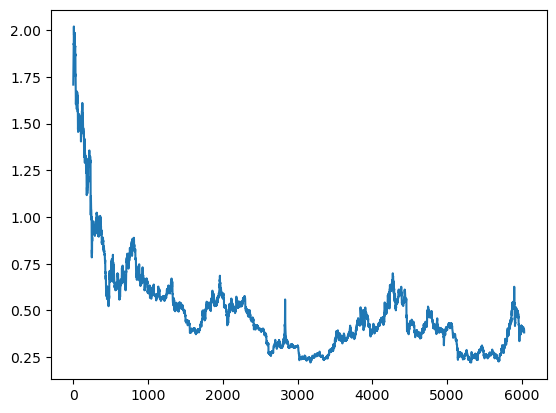

In [146]:
df_returns[df_returns['ticker'] == '1INCH-USD']['close'].plot()

<Axes: >

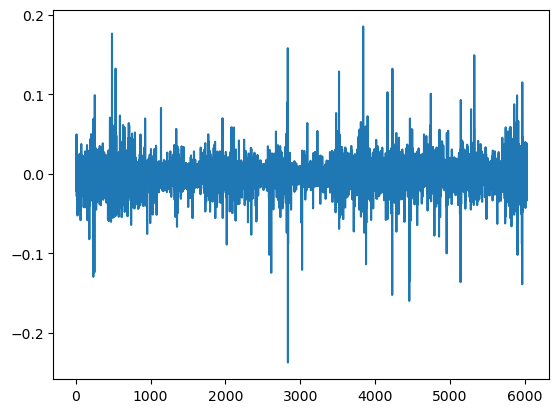

In [184]:
df_returns[df_returns['ticker'] == '1INCH-USD']['close_log_return_prev_4h'].plot()

<Axes: >

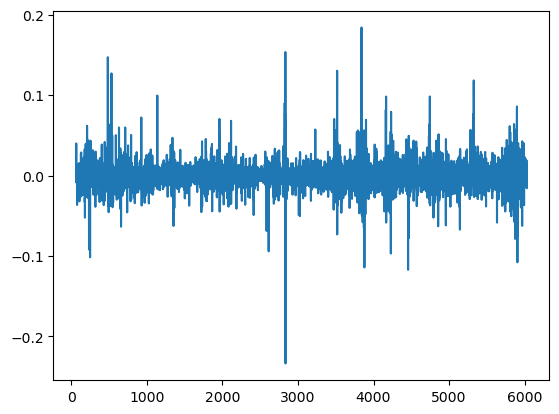

In [148]:
df_returns[df_returns['ticker'] == '1INCH-USD']['resid_btc_prev_4h'].plot()

<Axes: >

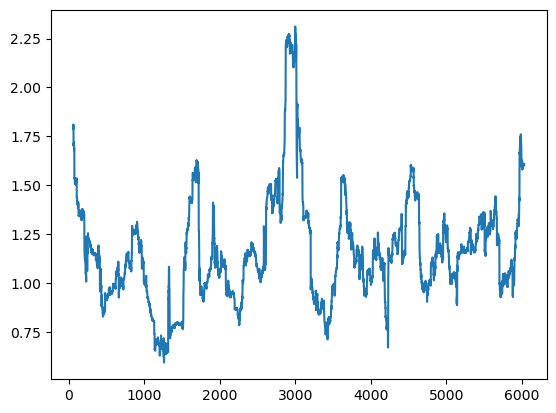

In [144]:
df_returns[df_returns['ticker'] == '1INCH-USD']['beta_btc'].plot()

<Axes: >

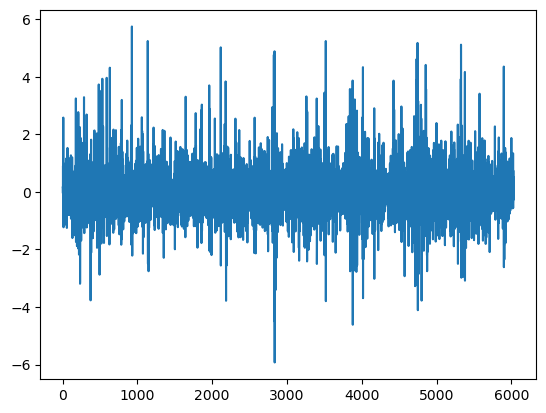

In [186]:
df_returns[df_returns['ticker'] == '1INCH-USD']['close_log_return_z_score_prev_4h'].plot()

<Axes: >

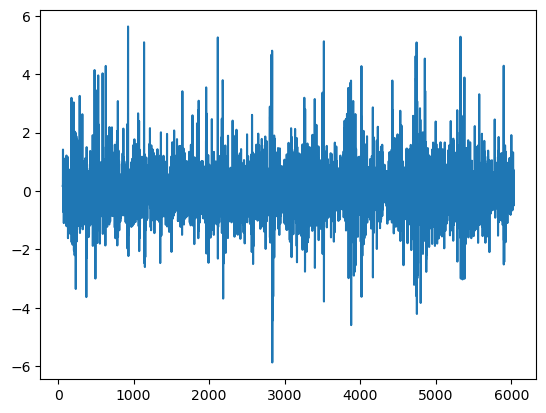

In [188]:
df_returns[df_returns['ticker'] == '1INCH-USD']['resid_btc_zscore_prev_4h'].plot()

In [192]:
df_returns[['close_log_return_z_score_prev_4h','resid_btc_zscore_prev_4h']].corr()

,close_log_return_z_score_prev_4h,resid_btc_zscore_prev_4h
close_log_return_z_score_prev_4h,1.00000,0.97181
resid_btc_zscore_prev_4h,0.97181,1.00000


In [166]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_btc_resid, df_daily_portfolio_with_t_cost_btc_resid = run_mean_reversion_backtest(df_signal_btc_residual_filt, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec')

df_daily_portfolio_with_t_cost_btc_resid['daily_pct_returns'] = df_daily_portfolio_with_t_cost_btc_resid['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_btc_resid['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_btc_resid, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.9478578547990066,
 'annualized_sharpe_ratio': -8.305594822634953,
 'calmar_ratio': -0.9481520442671846,
 'annualized_std_dev': 0.3527275099203719,
 'max_drawdown': -0.9996917070613222,
 'max_drawdown_duration': Timedelta('166 days 08:00:00'),
 'hit_rate': 0.28428428428428426,
 't_statistic': -13.503888770059437,
 'p_value': 2.7371385730052825e-38,
 'trade_count': 999.0}

In [180]:
df_daily_portfolio_with_t_cost_btc_resid.head(20)

,total_position_notional,available_cash,total_portfolio_value,total_portfolio_value_upper_limit,buy_notional_gross,sell_notional_gross,gross_traded_notional,turnover_pct,turnover_pct_half,buy_turnover_pct,sell_turnover_pct,daily_pct_returns,count_of_trades,strategy_cumulative_return,equity_curve,equity_curve_cum_max,drawdown,drawdown_pct,End,Start,equity_curve_DDDuration,profitable_trade
date,,,,,,,,,,,,,,,,,,,,,,
2022-04-11 12:00:00,296.190000,700.000000,996.190000,896.571000,300.000000,0.000000,300.000000,0.301147,0.150574,0.301147,0.000000,0.000000,1.0,0.000000,1.000000,1.0,0.000000,0.000000,2022-04-11 12:00:00,1,166 days 08:00:00,False
2022-04-11 16:00:00,587.902863,401.918038,989.820901,890.838811,298.081962,0.000000,298.081962,0.301147,0.150574,0.301147,0.000000,-0.006393,1.0,-0.006393,0.993607,1.0,-0.006393,-0.006393,2022-04-11 16:00:00,1,166 days 08:00:00,False
2022-04-11 20:00:00,877.475711,105.805489,983.281200,884.953080,296.112549,0.000000,296.112549,0.301147,0.150574,0.301147,0.000000,-0.006607,1.0,-0.012958,0.987042,1.0,-0.012958,-0.012958,2022-04-11 20:00:00,1,166 days 08:00:00,False
2022-04-12 00:00:00,860.392311,97.467286,957.859597,862.073637,291.636597,286.942565,578.579163,0.604033,0.302017,0.304467,0.299566,-0.025854,1.0,-0.038477,0.961523,1.0,-0.038477,-0.038477,2022-04-12 00:00:00,1,166 days 08:00:00,False
2022-04-12 04:00:00,858.771358,95.667602,954.438960,858.995064,286.161722,288.019890,574.181612,0.601591,0.300795,0.299822,0.301769,-0.003571,1.0,-0.041911,0.958089,1.0,-0.041911,-0.041911,2022-04-12 04:00:00,1,166 days 08:00:00,False
2022-04-12 08:00:00,869.003759,96.960408,965.964167,869.367750,286.607432,291.603604,578.211036,0.598584,0.299292,0.296706,0.301878,0.012075,1.0,-0.030341,0.969659,1.0,-0.030341,-0.030341,2022-04-12 08:00:00,1,166 days 08:00:00,True
2022-04-12 12:00:00,870.529564,103.964207,974.493771,877.044394,290.230355,301.057584,591.287939,0.606764,0.303382,0.297827,0.308937,0.008830,1.0,-0.021779,0.978221,1.0,-0.021779,-0.021779,2022-04-12 12:00:00,1,166 days 08:00:00,True
2022-04-12 16:00:00,856.122818,102.619693,958.742511,862.868260,289.505495,291.867702,581.373196,0.606391,0.303196,0.301964,0.304428,-0.016164,1.0,-0.037591,0.962409,1.0,-0.037591,-0.037591,2022-04-12 16:00:00,1,166 days 08:00:00,False
2022-04-12 20:00:00,827.168991,96.007937,923.176928,830.859235,278.012305,274.891673,552.903978,0.598914,0.299457,0.301147,0.297767,-0.037096,1.0,-0.073292,0.926708,1.0,-0.073292,-0.073292,2022-04-12 20:00:00,1,166 days 08:00:00,False


<Axes: xlabel='date'>

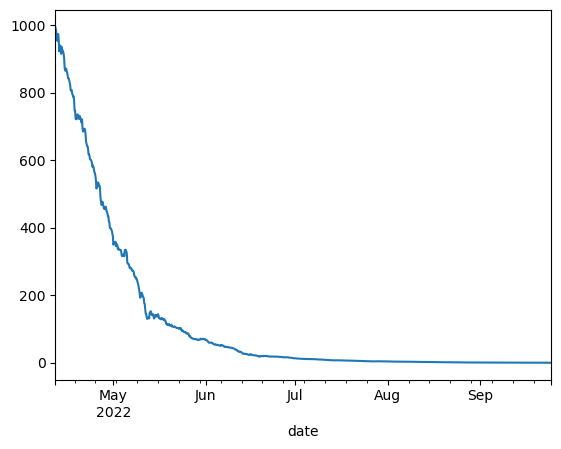

In [182]:
df_daily_portfolio_with_t_cost_btc_resid['total_portfolio_value'].plot()